# Detection and localization of failures of the ODIN UAV inertial navigation system
There are 4 datasets with data at different longitudinal speeds of the object. Each dataset contains 280 measurements series of INS readings (each series lasts 50 seconds with an interval of 0.01).

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import glob
import seaborn as sns
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

from keras import Sequential
from keras.layers import Dense, Conv1D, LSTM, MaxPooling1D, Dropout, Flatten, LeakyReLU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from tensorflow_addons.metrics import F1Score

from xgboost import XGBClassifier
import optuna

np.random.seed(0)

## Data import

In [2]:
file = 'dataset/velocity2/experiment121.csv'
df = pd.read_csv(file, usecols = ['u1', 'u2', 'y1', 'y2', 'y_nominal1', 'y_nominal2',
                                          'fault_u1', 'fault_u2', 'fault_y1', 'fault_y2', 'comp_fault'])
df.head()

,u1,u2,y1,y2,y_nominal1,y_nominal2,fault_u1,fault_u2,fault_y1,fault_y2,comp_fault
0,-0.240246,-0.228259,-0.087066,-0.321061,-0.009765,-0.344491,0.0,0.0,0.0,0.0,0.0
1,-0.240246,-0.228259,0.015985,-0.164281,-0.009262,-0.161122,0.0,0.0,0.0,0.0,0.0
2,-0.240246,-0.228259,-0.036406,-0.143049,-0.004363,-0.070550,0.0,0.0,0.0,0.0,0.0
3,-0.240246,-0.228259,0.024768,-0.064049,-0.001919,-0.030836,0.0,0.0,0.0,0.0,0.0
4,-0.240246,-0.228259,-0.082591,-0.065805,-0.000846,-0.013743,0.0,0.0,0.0,0.0,0.0


The data is a time series:

- u1, u2 are control signals
- y1, y2 are gyroscope and accelerometer measurements
- y_nominal1, y_nominal2 are expected gyroscope and accelerometer readings
- fault_u1, fault_u2 are control system failures labels (not present in the dataset and are not considered)
- fault_y1, fault_y2 are gyroscope and accelerometer failures labels (0 - no failure, other values - various forms of failures)
- comp_fault is UAV component failure label (not present in the dataset and not considered)

It is necessary to determine if there is a failure of the inertial navigation system (gyroscope or accelerometer). **Target**: fault_y1, fault_y2

It is required to solve the problem of classifying time series. Choose f1-score as a metric; for clarity, we will also consider the confusion matrix

Consider a window of length 20 measurements with sampling time (0.1 second). Define that a failure has occurred if the target variable has a non-zero value throughout the entire window.

In [3]:
files = glob.glob('dataset/*/*.csv')

sampling = 0.01
step = 0.1
measurement_step = int(step / sampling)

data = []
for file in files:
  if(file != 'data_model.csv'):
      temp = pd.read_csv(file, usecols = ['u1', 'u2', 'y1', 'y2', 'y_nominal1', 'y_nominal2',
                                          'fault_u1', 'fault_u2', 'fault_y1', 'fault_y2', 'comp_fault'])
      indexes = range(0, temp.shape[0], measurement_step)
      temp = temp.iloc[indexes][:]
      temp.reset_index(inplace=True)
      data.append(temp)      
len(data)

KeyboardInterrupt: 

Let's remove the lines that are not related to the INS failure and replace the non-zero failure values with 1

In [ ]:
drop_cols = ['fault_u1', 'fault_u2', 'comp_fault', 'index']

for experiment in data:
    experiment.drop(drop_cols, inplace=True, axis=1)
    experiment['fault_y1'].replace([1., 2., 3,], 1, inplace=True)
    experiment['fault_y2'].replace([1., 2., 3,], 1, inplace=True)
data[23].head()

,u1,u2,y1,y2,y_nominal1,y_nominal2,fault_y1,fault_y2
0,0.295509,-0.106547,0.011852,-0.003908,0.006568,-0.066288,0.0,0.0
1,0.295509,-0.106547,-0.018340,0.025243,0.000022,-0.000476,0.0,0.0
2,0.295509,-0.106547,0.012469,0.055155,0.000021,-0.000435,0.0,0.0
3,0.295509,-0.106547,-0.039980,-0.003755,0.000021,-0.000435,0.0,0.0
4,0.295509,-0.106547,-0.049325,-0.037429,0.000021,-0.000435,0.0,0.0


In [ ]:
data[133].shape

(50, 8)

Plot measurement signal

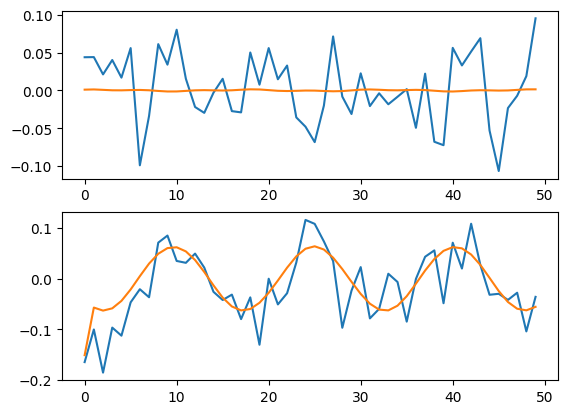

In [ ]:
n= 215
y1 = data[n]['y1']
y2 = data[n]['y2']
y_nominal1 = data[n]['y_nominal1']	
y_nominal2 = data[n]['y_nominal2']

fig, axs = plt.subplots(2, 1)
axs[0].plot(y1)
axs[0].plot(y_nominal1)
axs[1].plot(y2)
axs[1].plot(y_nominal2)

The data is highly noised. Therefore it is necessary to add filters for initial dataset. Lets's use moving average filter.

In [27]:
class RollngMeanFilter(BaseEstimator, TransformerMixin):
    def __init__(self, width=5, drop=False, cols=None):
        self.width = width
        self.drop = drop
        self.cols = cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y = None):
        if self.cols is None:
            self.cols = X.columns
        result = pd.DataFrame()
        for col in X.columns:
            if col in self.cols:            
                data = np.array(X[col])
                if self.drop == False:
                    data = np.concatenate([np.zeros(self.width-1), data])
                    result[col+'_roll_mean_'+str(self.width)] = X[col].rolling(self.width).mean()
                else:
                    result[col+'_roll_mean_'+str(self.width)] = X[col].rolling(self.width, min_periods=self.width).mean().dropna()    
            else:
                result[col] = X[col]                
        return result

In [28]:
data = []
filter_cols = ['y1', 'y2']
filter = RollngMeanFilter(width=20, drop=False, cols=filter_cols)
for file in files:
  if(file != 'data_model.csv'):
      temp = pd.read_csv(file, usecols = ['u1', 'u2', 'y1', 'y2', 'y_nominal1', 'y_nominal2',
                                          'fault_u1', 'fault_u2', 'fault_y1', 'fault_y2', 'comp_fault'])
      temp.drop(['fault_u1', 'fault_u2', 'comp_fault'], inplace=True, axis=1)
      for col in filter_cols:
        temp = filter.fit_transform(temp)
      temp.dropna(inplace=True)
      indexes = range(0, temp.shape[0], measurement_step)
      temp = temp.iloc[indexes][:]
      data.append(temp)      
len(data), data[0].shape

(1120, (49, 8))

In [29]:
data[0].head()

,u1,u2,y1_roll_mean_20,y2_roll_mean_20,y_nominal1,y_nominal2,fault_y1,fault_y2
19,0.207286,-0.045045,0.004724,0.020806,0.000013,-0.000179,0.0,0.0
29,0.207286,-0.045045,0.013496,-0.013669,0.000013,-0.000180,0.0,0.0
39,0.207286,-0.045045,0.003155,-0.004646,0.000013,-0.000180,0.0,0.0
49,0.207286,-0.045045,-0.011464,0.001966,0.000013,-0.000180,0.0,0.0
59,0.207286,-0.045045,-0.006046,-0.000617,0.000013,-0.000180,0.0,0.0


In [30]:
data[0].shape

(49, 8)

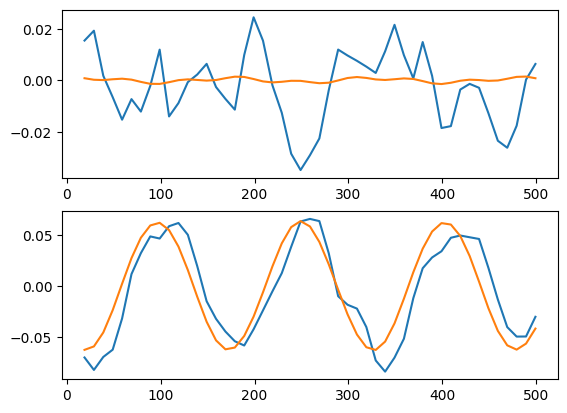

In [31]:
n= 215
y1 = data[n]['y1_roll_mean_20']
y2 = data[n]['y2_roll_mean_20']
y_nominal1 = data[n]['y_nominal1']	
y_nominal2 = data[n]['y_nominal2']

fig, axs = plt.subplots(2, 1)
axs[0].plot(y1)
axs[0].plot(y_nominal1)
axs[1].plot(y2)
axs[1].plot(y_nominal2)

In [32]:
for dataset in data:
    dataset.rename(columns={'y1_roll_mean_20': 'y1', 'y2_roll_mean_20': 'y2'}, inplace=True)
    dataset.reset_index(inplace=True, drop=True)
data[0].head()

,u1,u2,y1,y2,y_nominal1,y_nominal2,fault_y1,fault_y2
0,0.207286,-0.045045,0.004724,0.020806,0.000013,-0.000179,0.0,0.0
1,0.207286,-0.045045,0.013496,-0.013669,0.000013,-0.000180,0.0,0.0
2,0.207286,-0.045045,0.003155,-0.004646,0.000013,-0.000180,0.0,0.0
3,0.207286,-0.045045,-0.011464,0.001966,0.000013,-0.000180,0.0,0.0
4,0.207286,-0.045045,-0.006046,-0.000617,0.000013,-0.000180,0.0,0.0


In [13]:
data[0].shape

(49, 8)

Let's create the dataset as follows:
- sliding window of length 20 for each experiment
- sensor failure has occurred if the failure signal has a value of 1 for >10 readings

In [14]:
window_size = 20

new_cols = []
for col in data[0].drop(['fault_y1', 'fault_y2'], axis=1).columns:
    new_cols += [col + '_' + str(i) for i in range(window_size)]
new_cols += ['fault_y1', 'fault_y2']

df = pd.DataFrame(data=None, columns=new_cols)
lag = window_size - 1
for k, experiment in enumerate(data):
    for i in range(lag, experiment.shape[0]):
        sample = []
        u1_data = list(experiment.loc[(i-lag):i]['u1'])
        u2_data = list(experiment.loc[(i-lag):i]['u2'])
        y1_data = list(experiment.loc[(i-lag):i]['y1'])
        y2_data = list(experiment.loc[(i-lag):i]['y1'])
        y_nominal1_data = list(experiment.loc[(i-lag):i]['y_nominal1'])
        y_nominal2_data = list(experiment.loc[(i-lag):i]['y_nominal2'])
        
        sample_fault_y1 = list(experiment.loc[(i-lag):i]['fault_y1'])
        if sum(sample_fault_y1) > 10:
            fault_y1_data = [1]
        else:
            fault_y1_data = [0]
            
        sample_fault_y2 = list(experiment.loc[(i-lag):i]['fault_y2'])
        if sum(sample_fault_y2) > 10:
            fault_y2_data = [1]
        else:
            fault_y2_data = [0]
        sample = u1_data + u2_data + y1_data + y2_data + y_nominal1_data + y_nominal2_data + fault_y1_data + fault_y2_data
        df.loc[len(df)] = sample
    if k % 100 == 0:
        print(k, ' of ', len(data))

0  of  1120
100  of  1120
200  of  1120
300  of  1120
400  of  1120
500  of  1120
600  of  1120
700  of  1120
800  of  1120
900  of  1120
1000  of  1120
1100  of  1120


In [15]:
df.shape

(33600, 122)

In [16]:
df.to_csv('dataset_preprocessed.csv')

## EDA
Consider the balance of the dataset

In [17]:
#df = pd.read_csv('dataset_preprocessed.csv', index_col=0)
df.head(10)

,u1_0,u1_1,u1_2,u1_3,u1_4,u1_5,u1_6,u1_7,u1_8,u1_9,...,y_nominal2_12,y_nominal2_13,y_nominal2_14,y_nominal2_15,y_nominal2_16,y_nominal2_17,y_nominal2_18,y_nominal2_19,fault_y1,fault_y2
0,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0
1,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0
2,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0
3,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0
4,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0
5,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0
6,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0
7,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0
8,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0
9,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0


In [18]:
n_faults_y1 = df['fault_y1'].value_counts()[1]
n_faults_y2 = df['fault_y2'].value_counts()[1]
n_no_faults = df.shape[0] - n_faults_y1 - n_faults_y2

data = dict(
    categories = ['Total', 'No fault', 'Fault','Fault y1', 'Fault y2'],
    parent = ['', 'Total', 'Total', 'Fault', 'Fault'],
    value = [df.shape[0], n_no_faults, n_faults_y1+n_faults_y2, n_faults_y1, n_faults_y2]
)

fig = px.sunburst(data, names='categories', parents='parent', values='value', branchvalues='total')
fig.show()

Let's consider the influence of different signals on the presence of a failure. For convenience, let's create a column with LE encoding

In [19]:
df['fault_LE'] = 0
df['fault_LE'].loc[ (df['fault_y1'] == 0) & (df['fault_y1'] == 0)] = 0
df['fault_LE'].loc[df['fault_y1'] == 1] = 1
df['fault_LE'].loc[df['fault_y2'] == 1] = 2
df['fault_LE'].value_counts()

0    15899
2     8863
1     8838
Name: fault_LE, dtype: int64

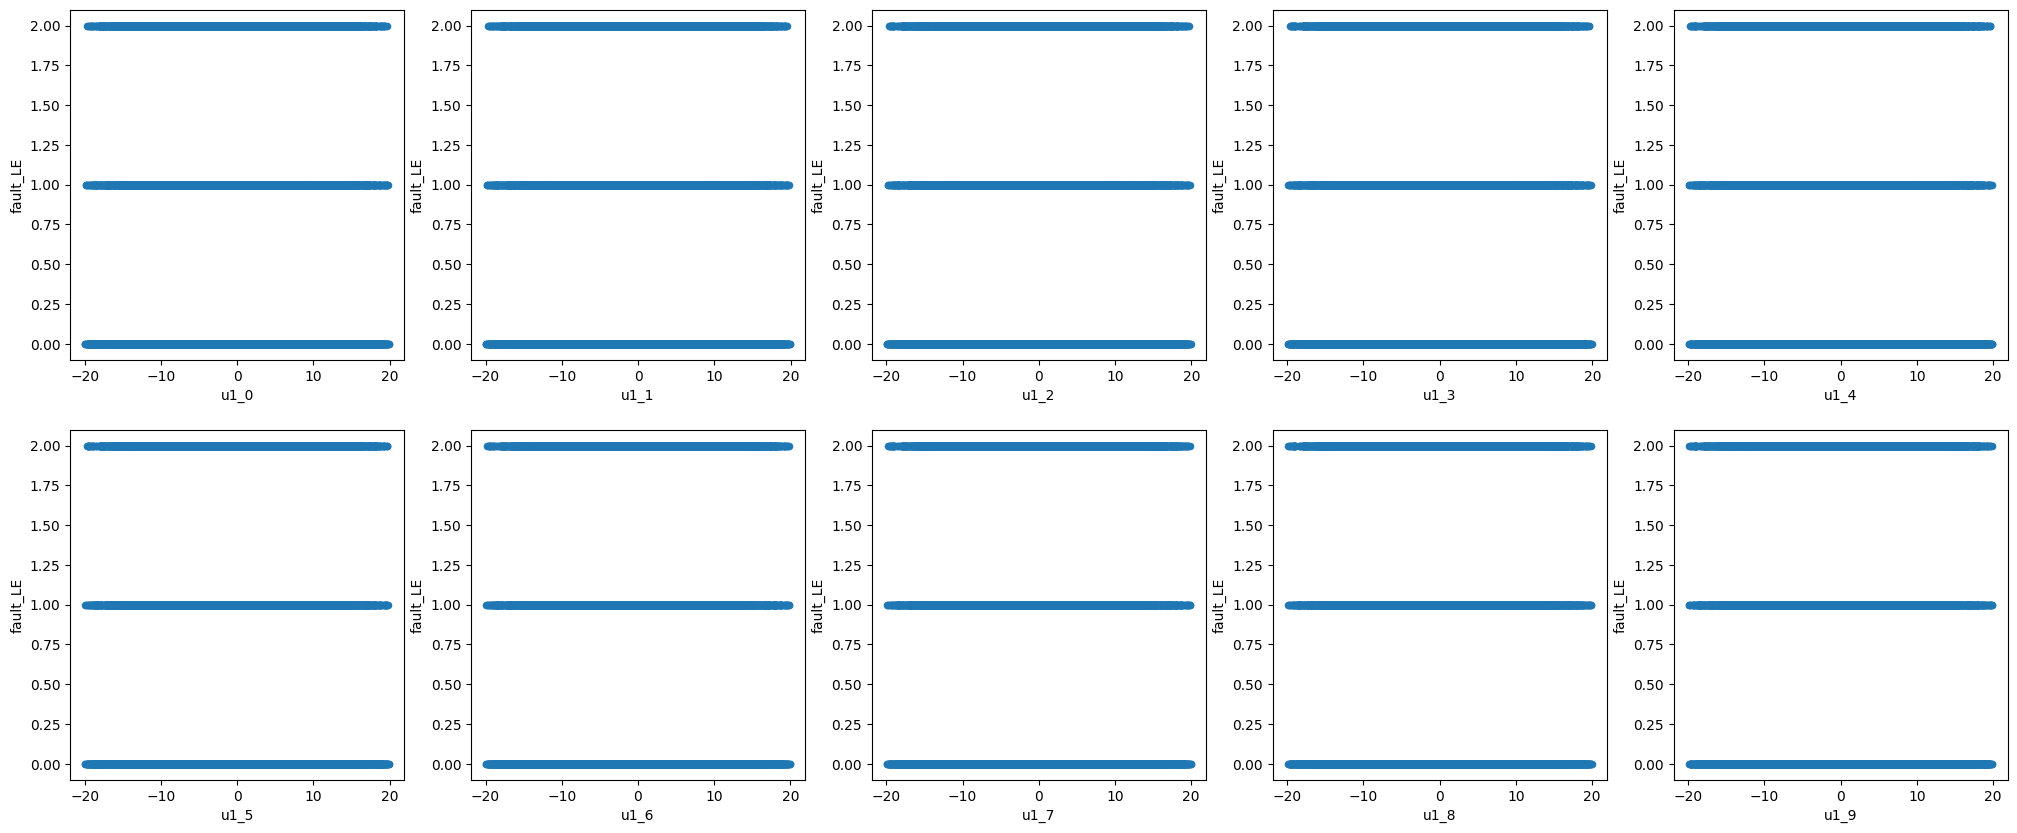

In [20]:
def plot_on_key(df, key):
    cols = [col for col in df.columns if key in col and 'fault' not in col][:10]
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))
    for idx, feature in enumerate(cols):
        df.plot(feature, "fault_LE", subplots=True, kind="scatter", ax=axes[idx // 5, idx % 5])
    plt.show()
plot_on_key(df, 'u1')

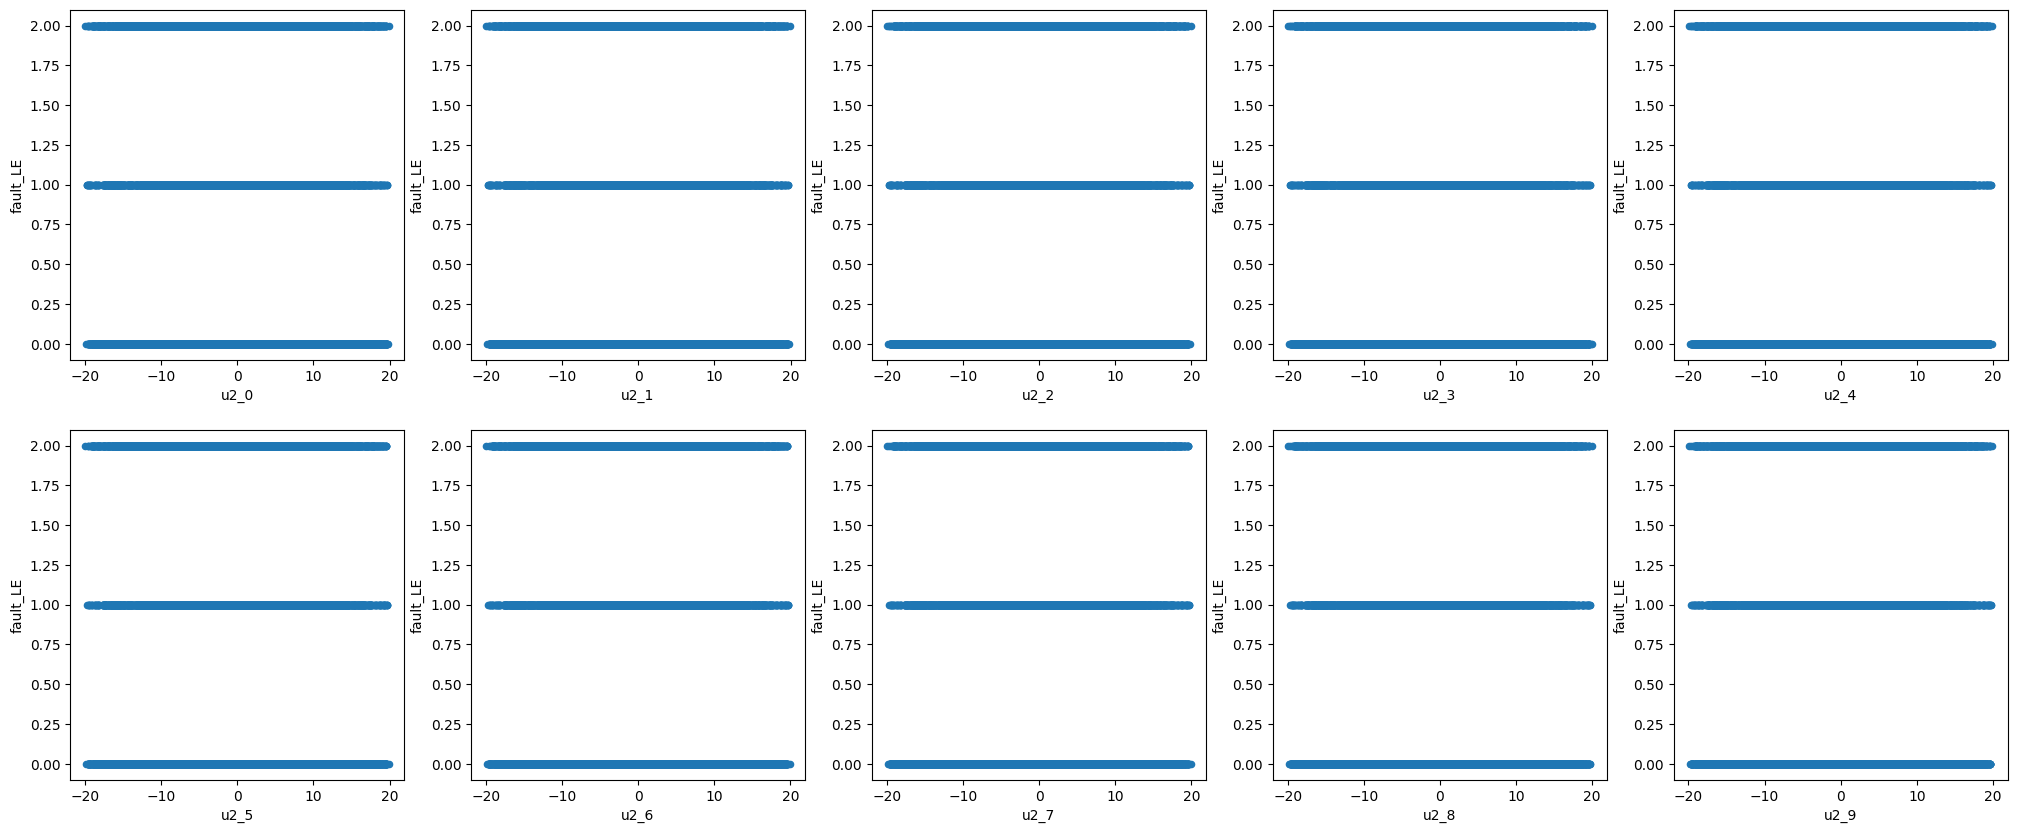

In [21]:
plot_on_key(df, 'u2')

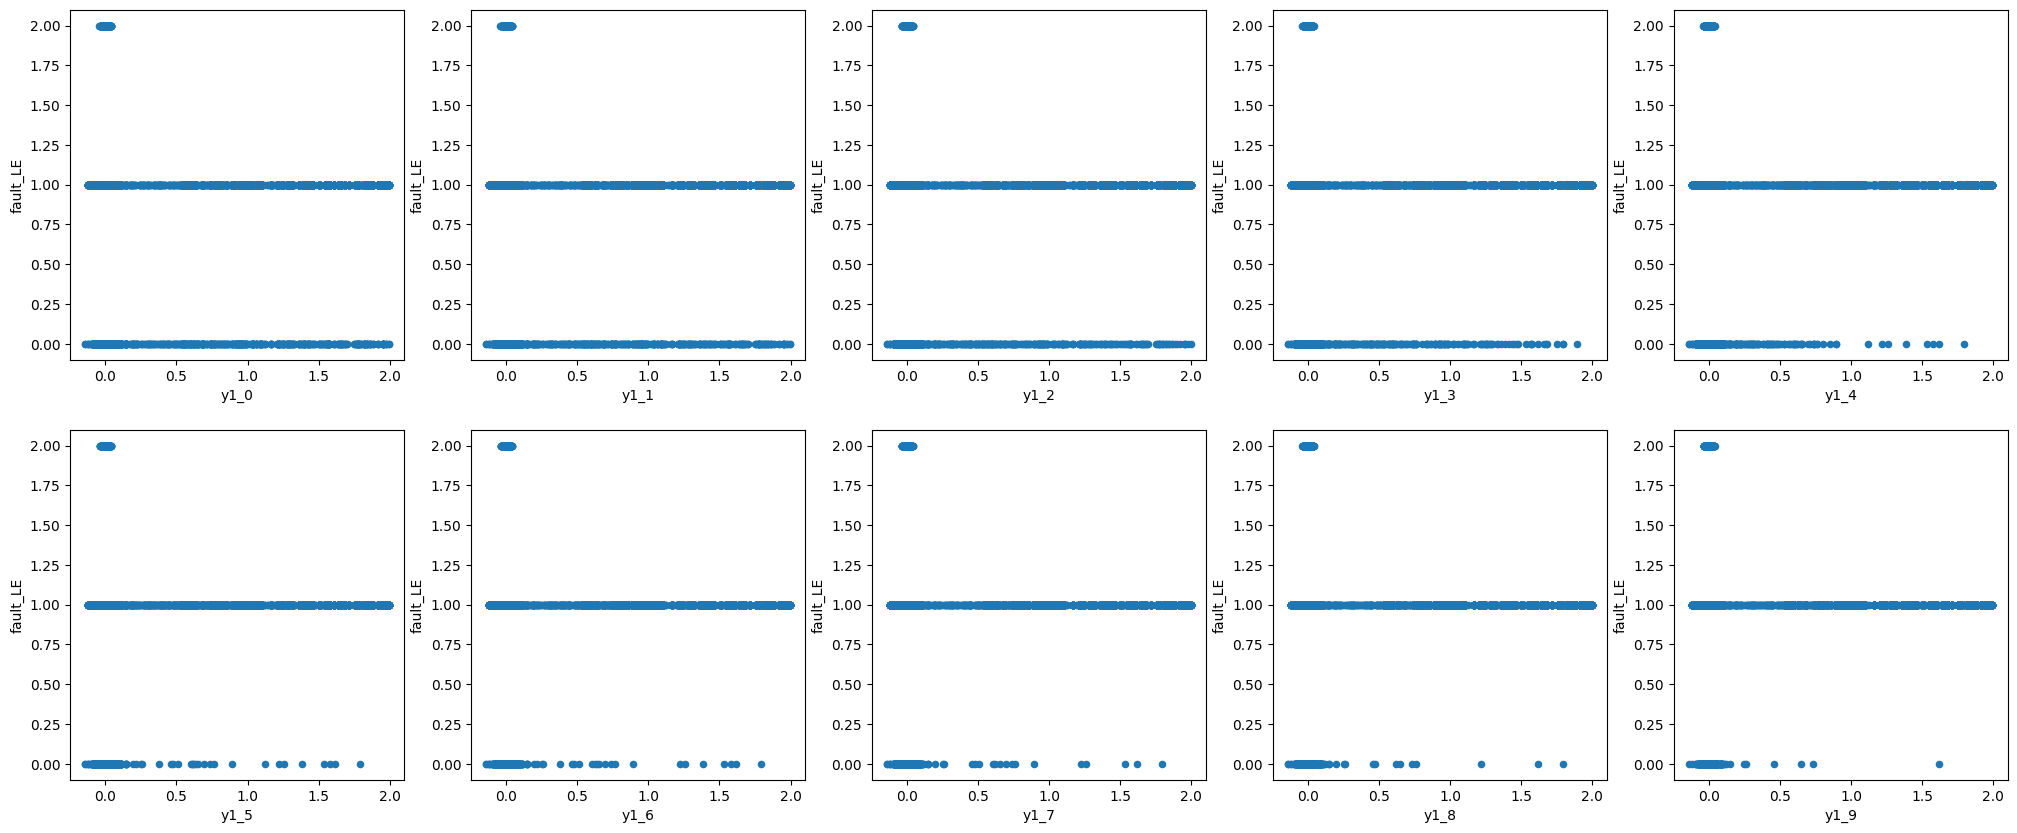

In [22]:
plot_on_key(df, 'y1')

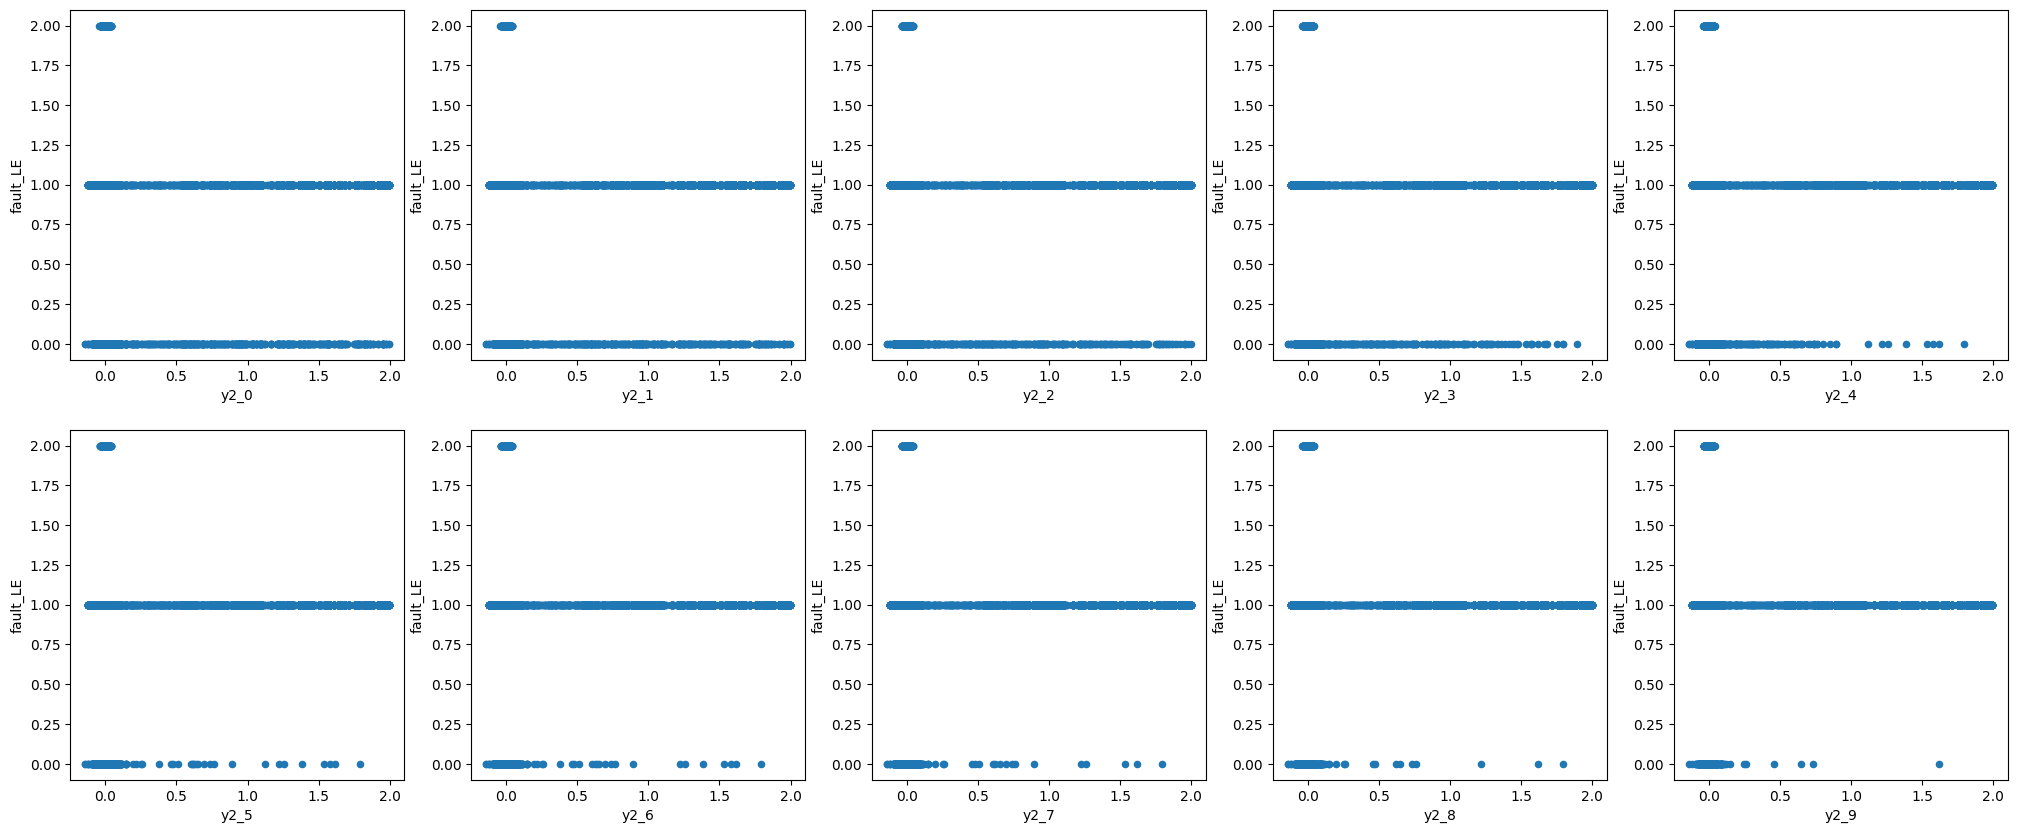

In [23]:
plot_on_key(df, 'y2')

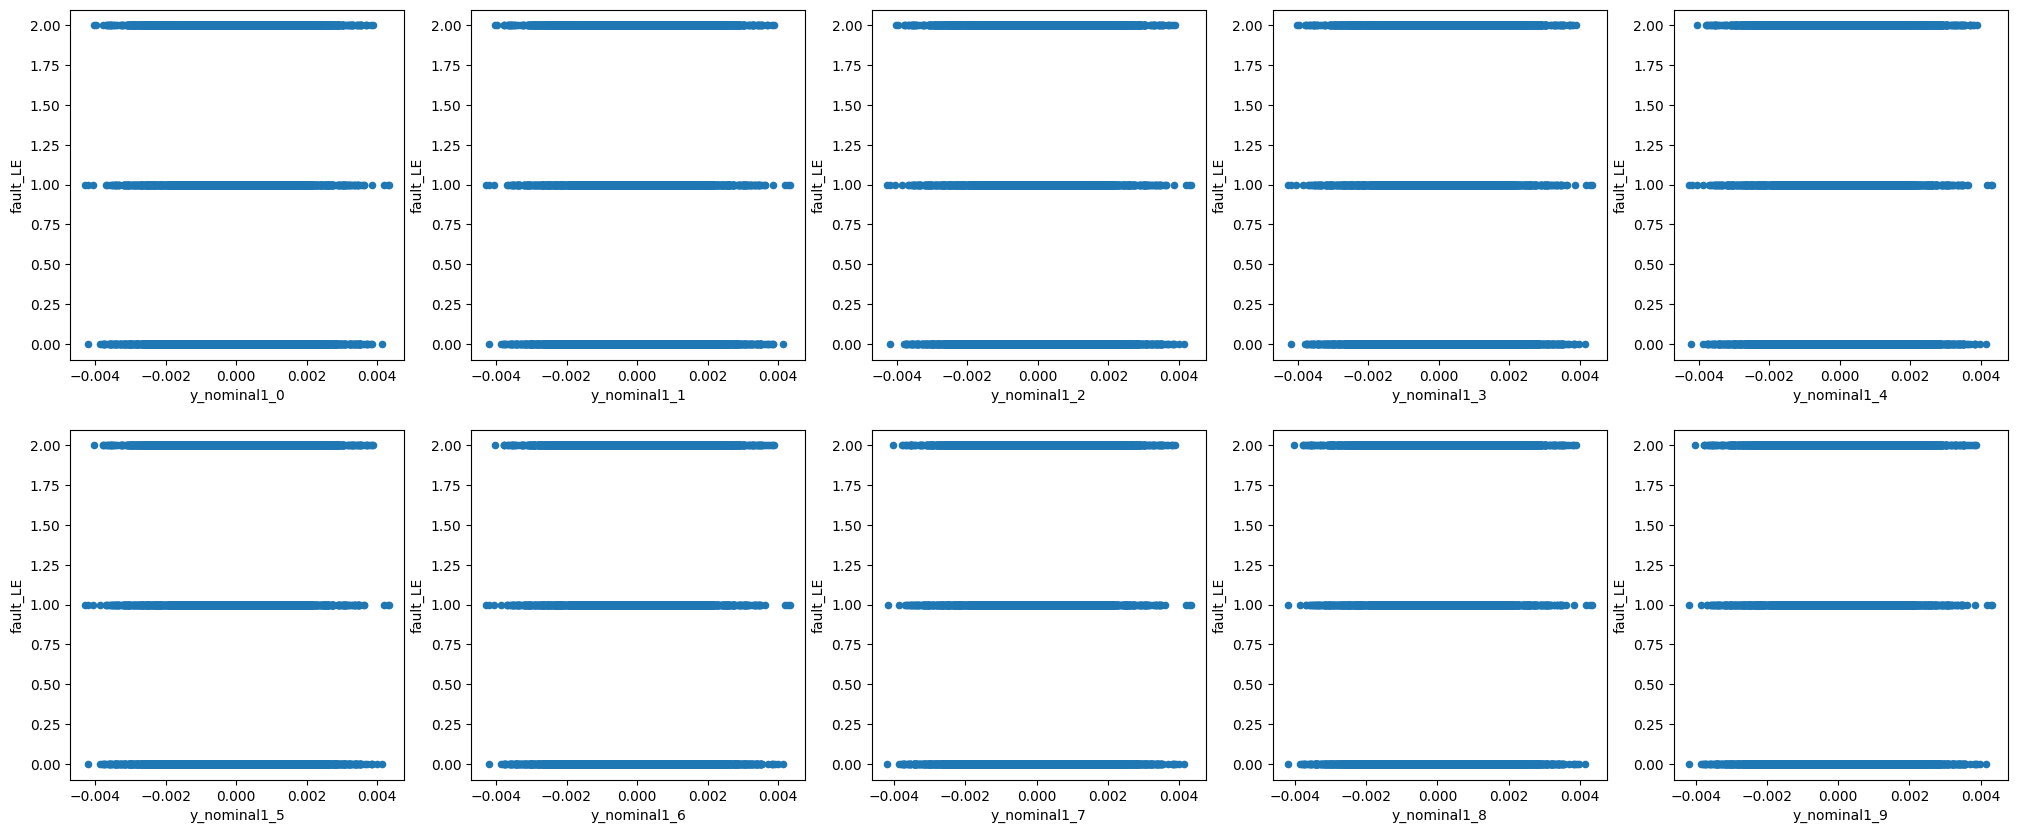

In [24]:
plot_on_key(df, 'y_nominal1')

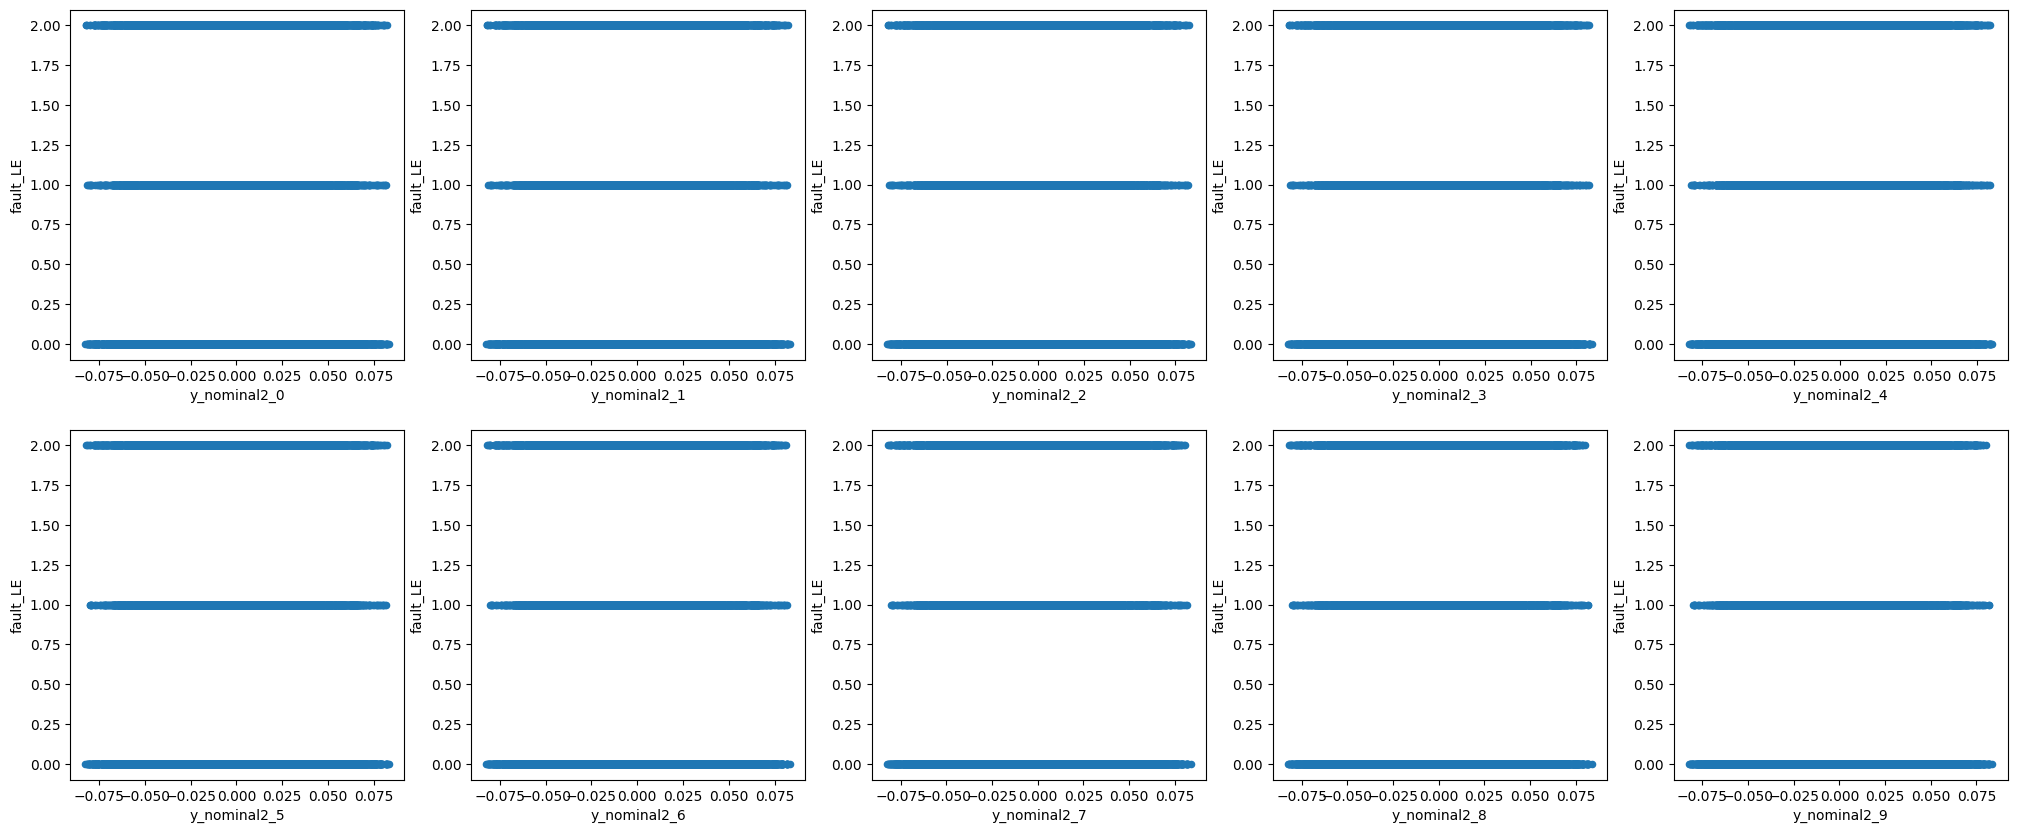

In [25]:
plot_on_key(df, 'y_nominal2')

No obvious dependencies found. Let's look at the distribution of features

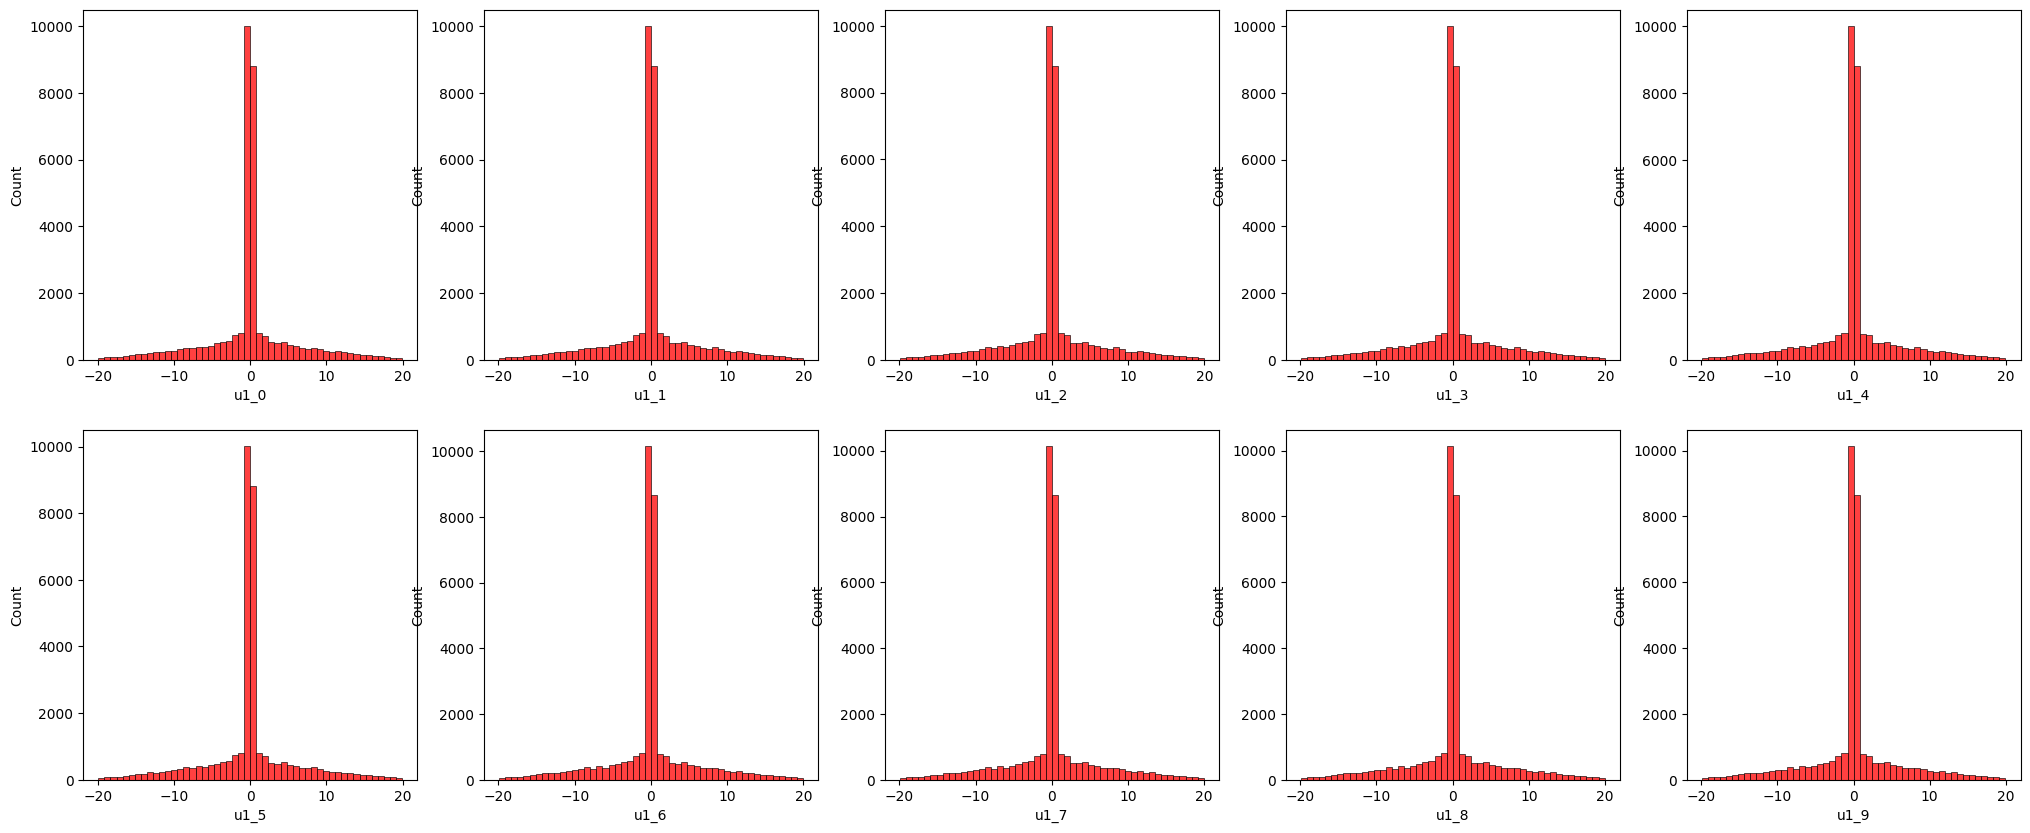

In [26]:
def distplot_on_key(df, key):
    cols = [col for col in df.columns if key in col and 'fault' not in col][:10]
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))
    for idx, feature in enumerate(cols):
        sns.histplot(df[feature], bins=50, color='r', ax=axes[idx // 5, idx % 5])
    plt.show()
distplot_on_key(df, 'u1')

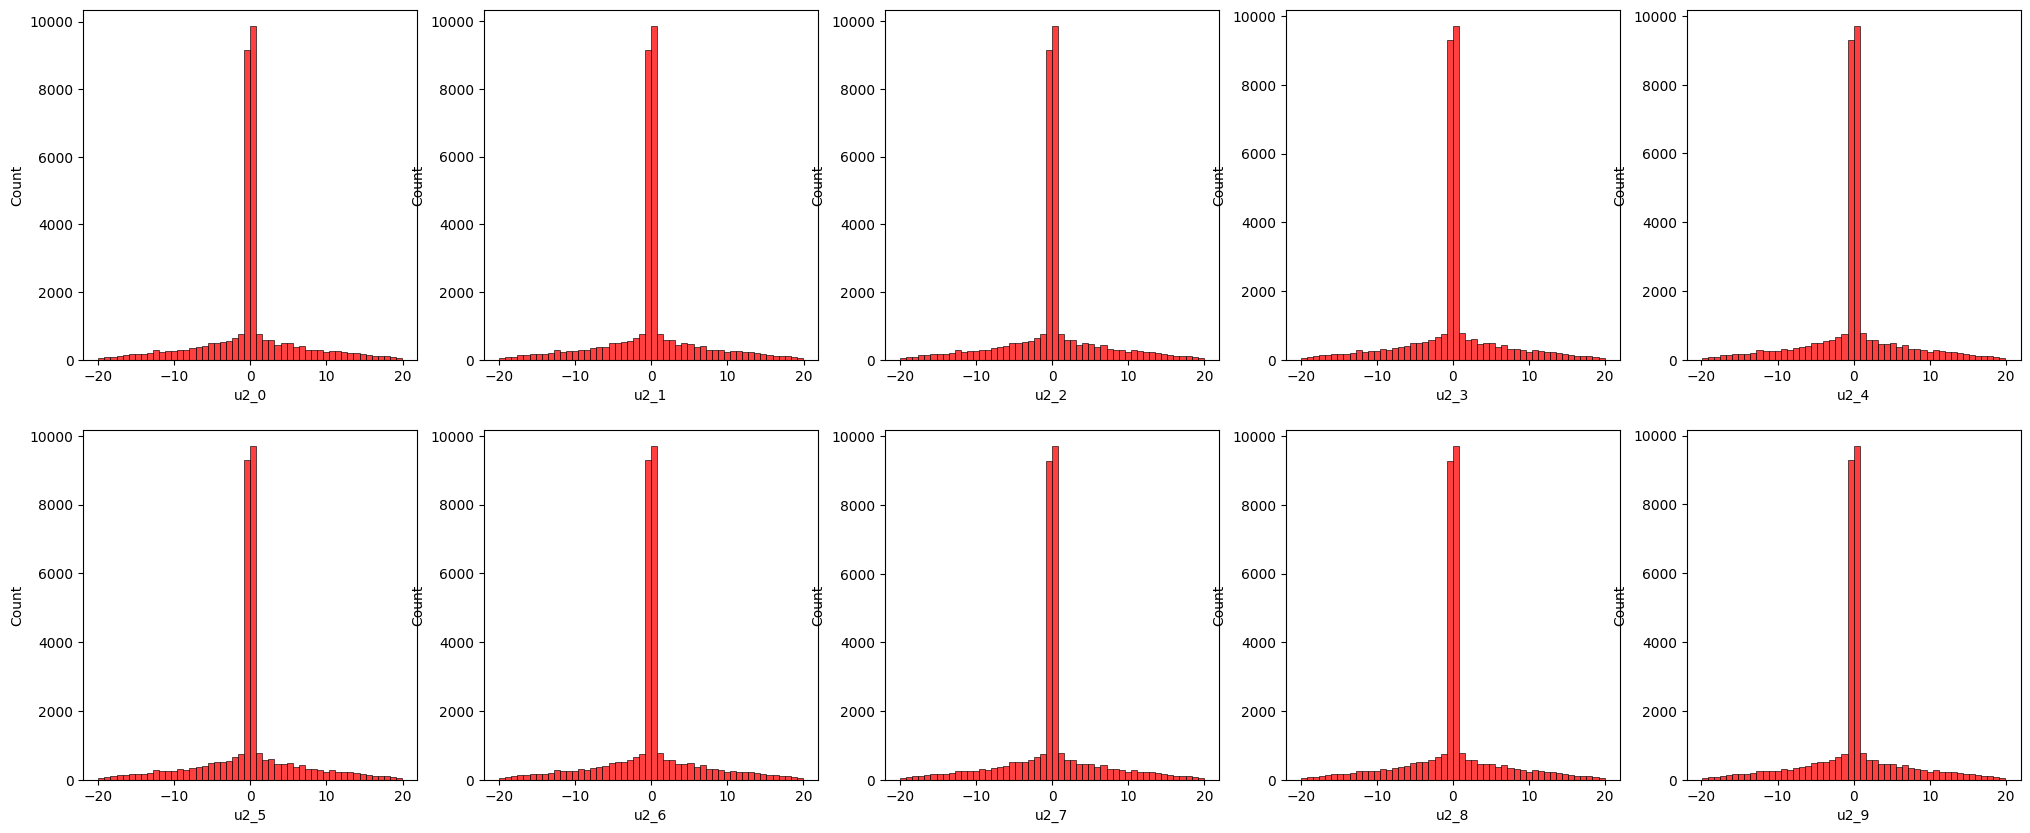

In [27]:
distplot_on_key(df, 'u2')

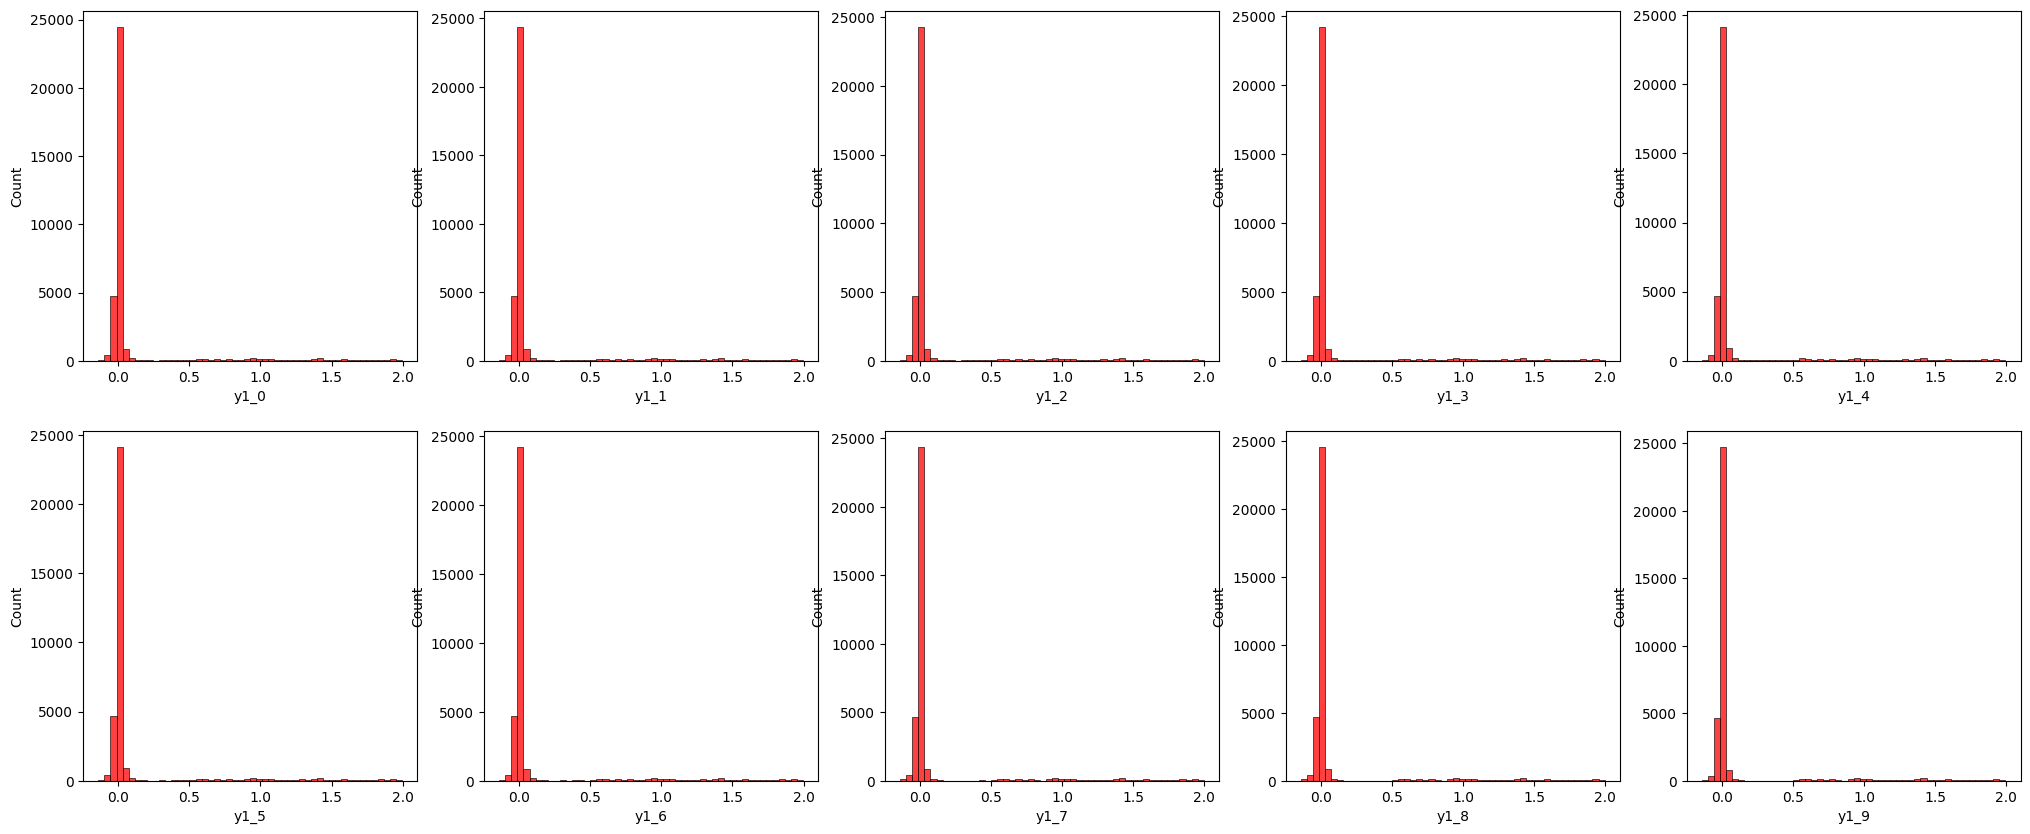

In [28]:
distplot_on_key(df, 'y1')

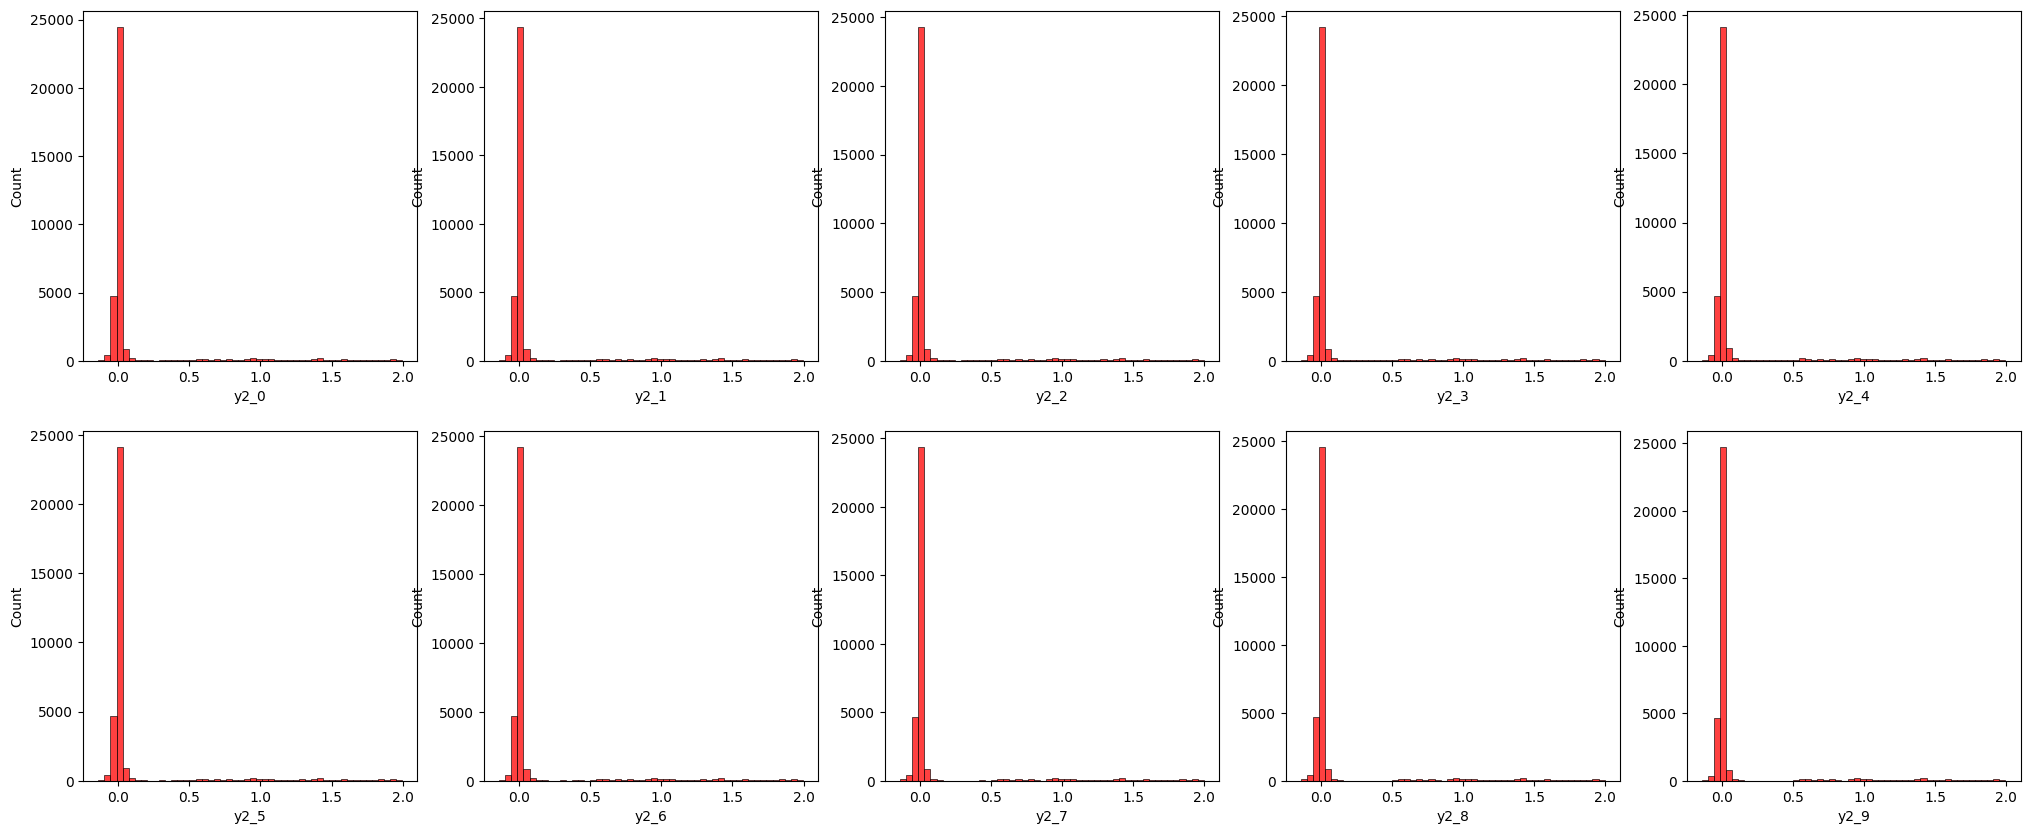

In [29]:
distplot_on_key(df, 'y2')

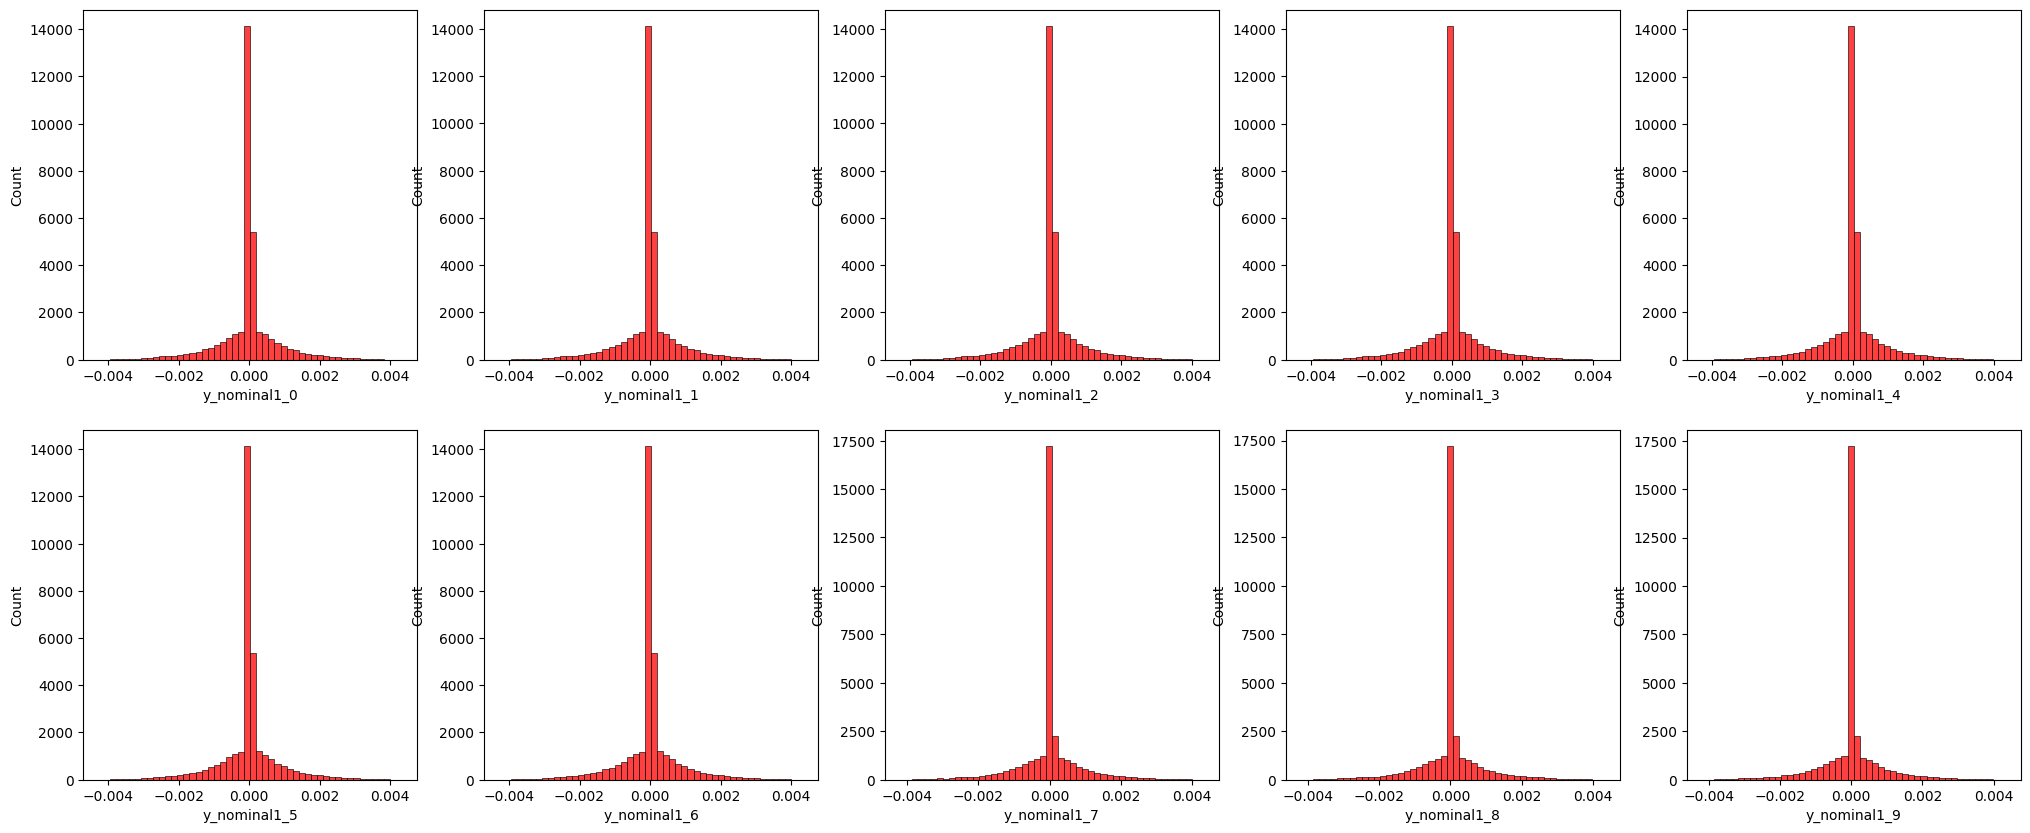

In [30]:
distplot_on_key(df, 'y_nominal1')

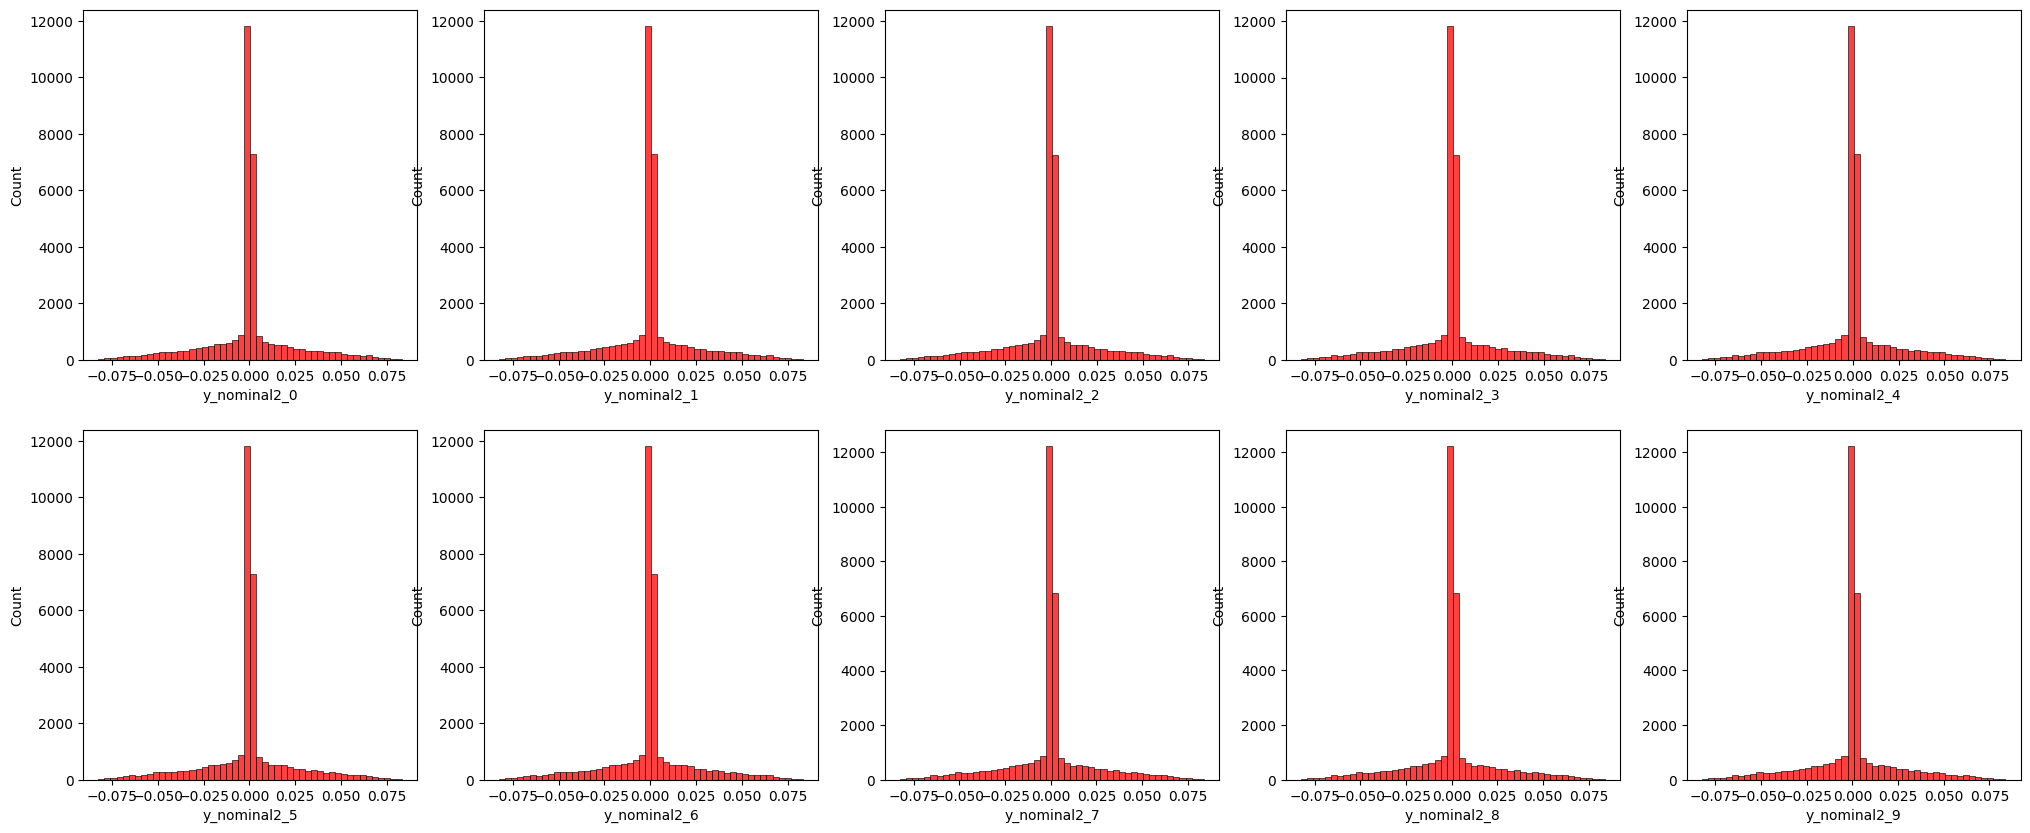

In [31]:
distplot_on_key(df, 'y_nominal2')

The distribution of all features is close to normal. Let's check the correlation of features

<Axes: >

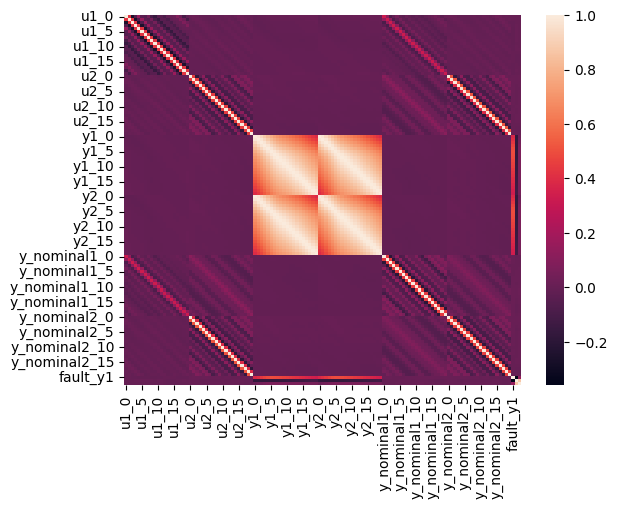

In [32]:
sns.heatmap(df.corr())

There are significantly correlated features, which is explained by the slow dynamics of the object.

In [33]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(['fault_y1', 'fault_y2', 'fault_LE'], axis=1))

model = PCA(n_components=3)
model.fit(df_scaled)
pca_coords = model.transform(df_scaled)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000


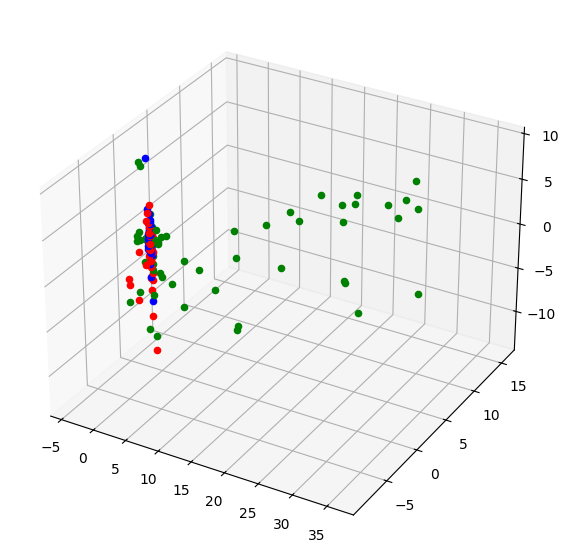

In [34]:
df_to_draw = pd.DataFrame({
    'class': df['fault_LE'],
    'pca1': pca_coords[:, 0],
    'pca2': pca_coords[:, 1],
    'pca3': pca_coords[:, 2],
})
colors = ['r', 'g', 'b']

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

for k, f in enumerate(df_to_draw.iterrows()):
    if k % 100 == 0:
        ax.scatter(f[1]['pca1'], f[1]['pca2'], f[1]['pca3'], c=colors[int(f[1]['class'])])
    if k % 1000 == 0:
        print(k)
plt.show()

Separability by plane isn't seen

## Feature engineering

Let's add moving averages with a window of 5 and 10

In [35]:
df_fe = df.copy()

cols = [col for col in df_fe.columns if ('y1' in col or
                                      'y2' in col or
                                      'u1' in col or
                                      'u2' in col) and 'fault' not in col]
for col in cols:
    df_fe['roll5_' + col] = df_fe[col].rolling(5).mean()
    df_fe['roll10_' + col] = df_fe[col].rolling(10).mean()

In [36]:
df_fe.shape

(33600, 283)

In [37]:
df_fe[[col for col in df_fe.columns if 'roll' in col]].describe()

,roll5_u1_0,roll10_u1_0,roll5_u1_1,roll10_u1_1,roll5_u1_2,roll10_u1_2,roll5_u1_3,roll10_u1_3,roll5_u1_4,roll10_u1_4,...,roll5_y2_15,roll10_y2_15,roll5_y2_16,roll10_y2_16,roll5_y2_17,roll10_y2_17,roll5_y2_18,roll10_y2_18,roll5_y2_19,roll10_y2_19
count,33596.000000,33591.000000,33596.000000,33591.000000,33596.000000,33591.000000,33596.000000,33591.000000,33596.000000,33591.000000,...,33596.000000,33591.000000,33596.000000,33591.000000,33596.000000,33591.000000,33596.000000,33591.000000,33596.000000,33591.000000
mean,-0.034916,-0.034972,-0.025852,-0.025907,-0.031895,-0.031950,-0.033438,-0.033494,-0.031589,-0.031644,...,0.068536,0.068545,0.064131,0.064140,0.059756,0.059765,0.055475,0.055482,0.051365,0.051372
std,2.939598,2.069000,2.938138,2.070661,2.930390,2.060875,2.926221,2.044811,2.916455,2.025903,...,0.282902,0.267329,0.273220,0.257277,0.263372,0.247065,0.253491,0.236850,0.243553,0.226635
min,-17.955529,-15.379557,-17.955529,-15.379557,-17.955529,-15.379557,-17.955529,-15.379557,-17.955529,-15.379557,...,-0.120747,-0.120747,-0.120747,-0.120747,-0.120747,-0.120747,-0.120747,-0.120747,-0.120747,-0.120747
25%,-0.403428,-0.339195,-0.398601,-0.334429,-0.400072,-0.336941,-0.402116,-0.338543,-0.400763,-0.335513,...,-0.004503,-0.003316,-0.004443,-0.003279,-0.004403,-0.003225,-0.004418,-0.003234,-0.004405,-0.003203
50%,-0.020345,-0.014905,-0.017378,-0.012269,-0.019531,-0.012920,-0.020380,-0.014296,-0.019192,-0.012513,...,0.000809,0.000764,0.000791,0.000736,0.000746,0.000738,0.000741,0.000723,0.000699,0.000685
75%,0.369967,0.295509,0.370337,0.299511,0.370337,0.297528,0.369720,0.296285,0.370337,0.297197,...,0.006539,0.005226,0.006459,0.005116,0.006338,0.004957,0.006222,0.004916,0.006138,0.004837
max,17.913529,15.434272,17.913529,15.434272,17.913529,15.598541,17.913529,15.434272,17.913529,15.062035,...,1.995495,1.995495,1.995495,1.995495,1.995495,1.995495,1.995495,1.995495,1.995495,1.995495


<Axes: >

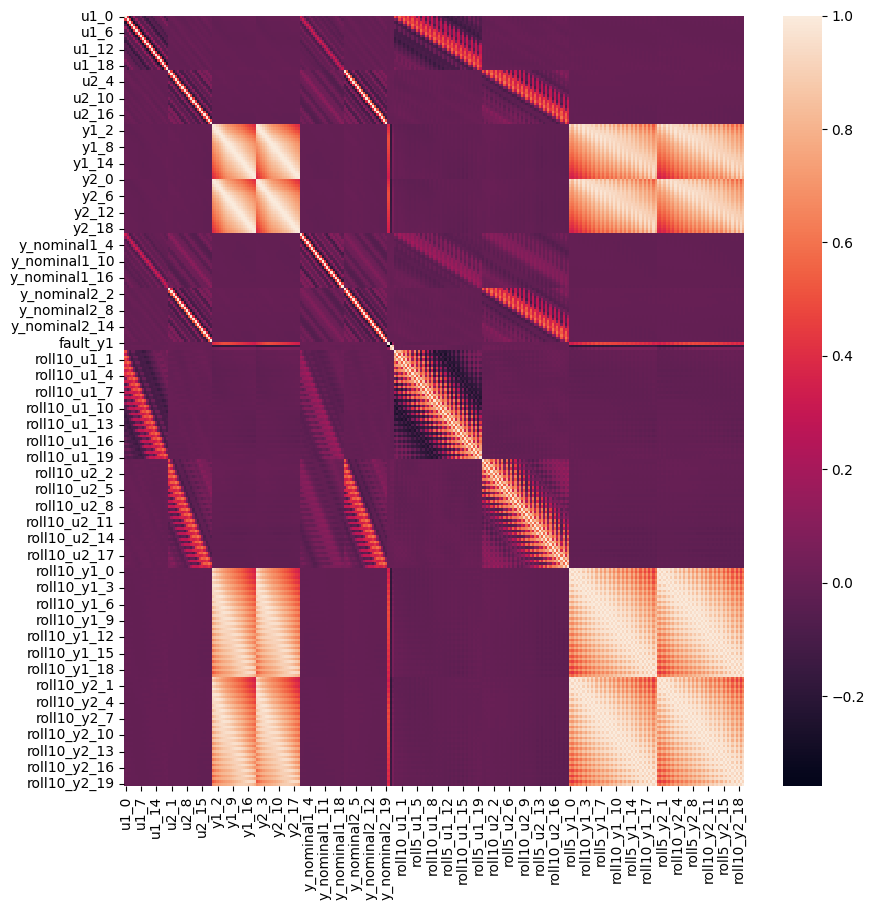

In [38]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(df_fe.corr())

Let's add the first derivatives

In [39]:
cols = [col for col in df_fe.columns if ('y1' in col or
                                      'y2' in col) and
        ('fault' not in col and 'roll' not in col)]
for col in cols:
    for i in range(1, 20):
        df_fe.loc[i, 'V_' + col] = df_fe.loc[i, col] - df_fe.loc[i-1, col]
df_fe.fillna(0, inplace=True)

df_fe.shape


(33600, 323)

In [40]:
scaler = StandardScaler()
df_fe[df_fe.drop(['fault_y1', 'fault_y2', 'fault_LE'], axis=1).columns] = scaler.fit_transform(df_fe.drop(['fault_y1', 'fault_y2', 'fault_LE'], axis=1))

Let's make PCA-transformed dataset

In [41]:
model = PCA(n_components=3)
pca3_df = model.fit_transform(df_fe.drop(['fault_y1', 'fault_y2', 'fault_LE'], axis=1))
df_fe3 = pd.DataFrame({'fault_LE': df_fe['fault_LE'], 'fault_y1': df_fe['fault_y1'], 'fault_y2': df_fe['fault_y2']})
for i in range(3):
   df_fe3['pca' + str(i)] = pca3_df[:, i]
   
model = PCA(n_components=10)
pca10_df = model.fit_transform(df_fe.drop(['fault_y1', 'fault_y2', 'fault_LE'], axis=1))
df_fe10 = pd.DataFrame({'fault_LE': df_fe['fault_LE'], 'fault_y1': df_fe['fault_y1'], 'fault_y2': df_fe['fault_y2']})
for i in range(10):
   df_fe10['pca' + str(i)] = pca10_df[:, i]
   
df_fe3.shape, df_fe10.shape 

((33600, 6), (33600, 13))

In [42]:
df_fe.to_csv('df_fe.csv')
df_fe3.to_csv('df_fe3.csv')
df_fe10.to_csv('df_fe10.csv')

## Baseline model selection

In [5]:
df = pd.read_csv('df_fe.csv', header=0, index_col=0)
df3 = pd.read_csv('df_fe3.csv', header=0, index_col=0)
df10 = pd.read_csv('df_fe10.csv', header=0, index_col=0)
df.head()

,u1_0,u1_1,u1_2,u1_3,u1_4,u1_5,u1_6,u1_7,u1_8,u1_9,...,V_y2_10,V_y2_11,V_y2_12,V_y2_13,V_y2_14,V_y2_15,V_y2_16,V_y2_17,V_y2_18,V_y2_19
0,0.043173,0.041602,0.042734,0.04302,0.042615,0.043497,0.042822,0.041435,0.042662,0.042804,...,0.000438,0.002219,0.001569,0.000219,-0.001226,-0.001179,0.002107,0.002982,0.003090,0.001811
1,0.043173,0.041602,0.042734,0.04302,0.042615,0.043497,0.042822,0.041435,0.042662,0.042804,...,8.073596,-15.950515,-28.617020,41.284595,-37.512694,44.158791,56.493824,-10.516167,-68.391412,34.783180
2,0.043173,0.041602,0.042734,0.04302,0.042615,0.043497,0.042822,0.041435,0.042662,0.042804,...,-16.639489,-28.523537,40.954852,-41.301228,44.234431,58.826050,-10.157003,-68.486013,32.529449,46.102451
3,0.043173,0.041602,0.042734,0.04302,0.042615,0.043497,0.042822,0.041435,0.042662,0.042804,...,-29.754116,40.822658,-40.968648,48.705235,58.926830,-10.580292,-66.142712,32.574280,43.114848,-68.400405
4,0.043173,0.041602,0.042734,0.04302,0.042615,0.043497,0.042822,0.041435,0.042662,0.042804,...,42.579292,-40.835099,48.315981,64.882083,-10.598471,-68.880594,31.458585,43.174304,-63.964349,-20.484585


In [6]:
df3.shape, df10.shape

((33600, 6), (33600, 13))

In [7]:
y_le = np.array(df['fault_LE'])
y_ohe = np.array(df[['fault_y1', 'fault_y2']])

X_array = np.array(df.drop(['fault_y1', 'fault_y2', 'fault_LE'], axis=1))
X3_array = np.array(df3.drop(['fault_y1', 'fault_y2', 'fault_LE'], axis=1))
X10_array = np.array(df10.drop(['fault_y1', 'fault_y2', 'fault_LE'], axis=1))

In [8]:
X_series = X_array.reshape((X_array.shape[0], 20, X_array.shape[1]//20))

In [9]:
X_array_train, X_array_test, y_le_train, y_le_test = train_test_split(X_array, y_le, stratify=y_le, test_size=0.25, random_state=0)
X3_array_train, X3_array_test, y3_le_train, y3_le_test = train_test_split(X3_array, y_le, stratify=y_le, test_size=0.25, random_state=0)
X10_array_train, X10_array_test, y10_le_train, y10_le_test = train_test_split(X10_array, y_le, stratify=y_le, test_size=0.25, random_state=0)
X_series_train, X_series_test, y_ohe_train, y_ohe_test = train_test_split(X_series, y_ohe, stratify=y_le, test_size=0.25, random_state=0)

X_array_train, X_array_val, y_le_train, y_le_val = train_test_split(X_array_train, y_le_train, stratify=y_le_train, test_size=0.25, random_state=0)
X3_array_train, X3_array_val, y3_le_train, y3_le_val = train_test_split(X3_array_train, y3_le_train, stratify=y3_le_train, test_size=0.25, random_state=0)
X10_array_train, X10_array_val, y10_le_train, y10_le_val = train_test_split(X10_array_train, y10_le_train, stratify=y10_le_train, test_size=0.25, random_state=0)
X_series_train, X_series_val, y_ohe_train, y_ohe_val = train_test_split(X_series_train, y_ohe_train, stratify=y_ohe_train, test_size=0.25, random_state=0)

### Dummy classifier for comparison

In [10]:
def print_result(y_true, y_pred):
    print('f1: ', f1_score(y_true, y_pred, average='macro'))
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    

In [10]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_array_train, y_le_train)
predictions = dummy_clf.predict(X_array_test)
print_result(y_le_test, predictions)

f1:  0.21414141414141416
[[3975    0    0]
 [2209    0    0]
 [2216    0    0]]
              precision    recall  f1-score   support

           0       0.47      1.00      0.64      3975
           1       0.00      0.00      0.00      2209
           2       0.00      0.00      0.00      2216

    accuracy                           0.47      8400
   macro avg       0.16      0.33      0.21      8400
weighted avg       0.22      0.47      0.30      8400



### Logistic regression
For PCA transformed datasets

In [15]:
parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty':['l2']},
              {'C':[0.001, 0.01, 0.1]}]
lr_grid = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=0), 
                       parameters, scoring='f1', 
                       cv=5, 
                       verbose=0, 
                       n_jobs=8)
lr_grid.fit(X3_array_train, y3_le_train)
predictions = lr_grid.predict(X3_array_val)
print_result(y3_le_val, predictions)

f1:  0.4454371960369216
[[ 720  106 2155]
 [ 311  650  696]
 [ 293    5 1364]]
              precision    recall  f1-score   support

           0       0.54      0.24      0.33      2981
           1       0.85      0.39      0.54      1657
           2       0.32      0.82      0.46      1662

    accuracy                           0.43      6300
   macro avg       0.57      0.48      0.45      6300
weighted avg       0.57      0.43      0.42      6300



In [16]:
parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty':['l2']},
              {'C':[0.001, 0.01, 0.1]}]
lr_grid = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=0), 
                       parameters, scoring='f1', 
                       cv=5, 
                       verbose=0, 
                       n_jobs=8)
lr_grid.fit(X10_array_train, y10_le_train)
predictions = lr_grid.predict(X10_array_val)
print_result(y10_le_val, predictions)

f1:  0.4788354190029791
[[ 885   14 2082]
 [ 290  690  677]
 [ 340    4 1318]]
              precision    recall  f1-score   support

           0       0.58      0.30      0.39      2981
           1       0.97      0.42      0.58      1657
           2       0.32      0.79      0.46      1662

    accuracy                           0.46      6300
   macro avg       0.63      0.50      0.48      6300
weighted avg       0.62      0.46      0.46      6300



In [17]:
parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty':['l2']},
              {'C':[0.001, 0.01, 0.1]}]
lr_grid = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=0), 
                       parameters, scoring='f1', 
                       cv=5, 
                       verbose=0, 
                       n_jobs=8)
lr_grid.fit(X_array_train, y_le_train)
predictions = lr_grid.predict(X_array_val)
print_result(y_le_val, predictions)

f1:  0.4752377690489246
[[1021  103 1857]
 [ 294  736  627]
 [ 464   79 1119]]
              precision    recall  f1-score   support

           0       0.57      0.34      0.43      2981
           1       0.80      0.44      0.57      1657
           2       0.31      0.67      0.43      1662

    accuracy                           0.46      6300
   macro avg       0.56      0.49      0.48      6300
weighted avg       0.56      0.46      0.47      6300



### Elastic net

In [136]:
elnet_clf = LogisticRegressionCV(penalty='elasticnet', Cs=[1e-3, 1e-2, 1e-1, 1],
                                 l1_ratios=[1e-3, 1e-2, 1e-1, 1], solver='saga', n_jobs=8)
elnet_clf.fit(X3_array_train, y3_le_train) 
predictions = elnet_clf.predict(X3_array_val)
print_result(y3_le_val, predictions)

f1:  0.4076954662459731
[[2919   55    7]
 [1009  633   15]
 [1657    3    2]]
              precision    recall  f1-score   support

           0       0.52      0.98      0.68      2981
           1       0.92      0.38      0.54      1657
           2       0.08      0.00      0.00      1662

    accuracy                           0.56      6300
   macro avg       0.51      0.45      0.41      6300
weighted avg       0.51      0.56      0.46      6300



In [137]:
elnet_clf = LogisticRegressionCV(penalty='elasticnet', Cs=[1e-3, 1e-2, 1e-1, 1],
                                 l1_ratios=[1e-3, 1e-2, 1e-1, 1], solver='saga', n_jobs=8)
elnet_clf.fit(X10_array_train, y10_le_train) 
predictions = elnet_clf.predict(X10_array_val)
print_result(y10_le_val, predictions)

f1:  0.4152414577512227
[[2974    1    6]
 [1024  633    0]
 [1656    2    4]]
              precision    recall  f1-score   support

           0       0.53      1.00      0.69      2981
           1       1.00      0.38      0.55      1657
           2       0.40      0.00      0.00      1662

    accuracy                           0.57      6300
   macro avg       0.64      0.46      0.42      6300
weighted avg       0.62      0.57      0.47      6300



In [138]:
elnet_clf = LogisticRegressionCV(penalty='elasticnet', Cs=[1e-3, 1e-2, 1e-1, 1],
                                 l1_ratios=[1e-3, 1e-2, 1e-1, 1], solver='saga', n_jobs=8)
elnet_clf.fit(X_array_train, y_le_train) 
predictions = elnet_clf.predict(X_array_val)
print_result(y_le_val, predictions)

f1:  0.4439215741497458
[[2910   21   50]
 [ 981  660   16]
 [1578   11   73]]
              precision    recall  f1-score   support

           0       0.53      0.98      0.69      2981
           1       0.95      0.40      0.56      1657
           2       0.53      0.04      0.08      1662

    accuracy                           0.58      6300
   macro avg       0.67      0.47      0.44      6300
weighted avg       0.64      0.58      0.50      6300



### K-NN

In [23]:
param_grid = {
    'n_neighbors': range(5, 50, 3),
    'weights': ('uniform', 'distance'),
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
knn_clf = GridSearchCV(KNeighborsClassifier(), param_grid, cv=StratifiedKFold(5), refit=True, verbose=0, n_jobs=8)

knn_clf.fit(X3_array_train, y3_le_train) 
predictions = knn_clf.predict(X3_array_val)
print('f1-score: ', f1_score(y3_le_val, predictions, average='macro'))
print_result(y3_le_val, predictions)

f1-score:  0.6266216595522021
f1:  0.6266216595522021
[[2415  103  463]
 [ 486 1024  147]
 [ 969   36  657]]
              precision    recall  f1-score   support

           0       0.62      0.81      0.71      2981
           1       0.88      0.62      0.73      1657
           2       0.52      0.40      0.45      1662

    accuracy                           0.65      6300
   macro avg       0.67      0.61      0.63      6300
weighted avg       0.66      0.65      0.64      6300



In [24]:
param_grid = {
    'n_neighbors': range(5, 50, 3),
    'weights': ('uniform', 'distance'),
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
knn_clf = GridSearchCV(KNeighborsClassifier(), param_grid, cv=StratifiedKFold(5), refit=True, verbose=0, n_jobs=8)

knn_clf.fit(X10_array_train, y10_le_train) 
predictions = knn_clf.predict(X10_array_val)
print_result(y3_le_val, predictions)

f1:  0.7293591693836476
[[2390  138  453]
 [ 291 1226  140]
 [ 575   60 1027]]
              precision    recall  f1-score   support

           0       0.73      0.80      0.77      2981
           1       0.86      0.74      0.80      1657
           2       0.63      0.62      0.63      1662

    accuracy                           0.74      6300
   macro avg       0.74      0.72      0.73      6300
weighted avg       0.74      0.74      0.74      6300



In [25]:
param_grid = {
    'n_neighbors': range(5, 50, 3),
    'weights': ('uniform', 'distance'),
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
knn_clf = GridSearchCV(KNeighborsClassifier(), param_grid, cv=StratifiedKFold(5), refit=True, verbose=0, n_jobs=8)

knn_clf.fit(X_array_train, y_le_train) 
predictions = knn_clf.predict(X_array_val)
print_result(y_le_val, predictions)

f1:  0.785880227801863
[[2524  123  334]
 [ 260 1301   96]
 [ 461   41 1160]]
              precision    recall  f1-score   support

           0       0.78      0.85      0.81      2981
           1       0.89      0.79      0.83      1657
           2       0.73      0.70      0.71      1662

    accuracy                           0.79      6300
   macro avg       0.80      0.78      0.79      6300
weighted avg       0.79      0.79      0.79      6300



Quitely good results

### SVM

In [26]:
param_grid = {
    'penalty': ['l2'],
    'loss': ['hinge', 'squared_hinge'],
    'C': [0.001, 0.01, 0.1],
    'dual': [False]
}
svm_lin_clf = GridSearchCV(LinearSVC(), param_grid, cv=StratifiedKFold(5), refit=True, verbose=0, n_jobs=8)

svm_lin_clf.fit(X3_array_train, y3_le_train) 
predictions = svm_lin_clf.predict(X3_array_val)
print_result(y3_le_val, predictions)

f1:  0.40682879483209927
[[2918   55    8]
 [1024  633    0]
 [1658    3    1]]
              precision    recall  f1-score   support

           0       0.52      0.98      0.68      2981
           1       0.92      0.38      0.54      1657
           2       0.11      0.00      0.00      1662

    accuracy                           0.56      6300
   macro avg       0.52      0.45      0.41      6300
weighted avg       0.52      0.56      0.46      6300



In [32]:
param_grid = {
    'C': [0.001, 0.01, 0.1],
    'kernel': ['rbf'],
    'class_weight': ['balanced']
}
svm_clf = GridSearchCV(SVC(), param_grid, cv=StratifiedKFold(5), refit=True, verbose=0, n_jobs=8)
svm_clf.fit(X3_array_train, y3_le_train) 
predictions = svm_clf.predict(X3_array_val)
print_result(y3_le_val, predictions)

f1:  0.3843182398849947
[[ 241   35 2705]
 [  60  637  960]
 [  54    5 1603]]
              precision    recall  f1-score   support

           0       0.68      0.08      0.14      2981
           1       0.94      0.38      0.55      1657
           2       0.30      0.96      0.46      1662

    accuracy                           0.39      6300
   macro avg       0.64      0.48      0.38      6300
weighted avg       0.65      0.39      0.33      6300



In [33]:
param_grid = {
    'C': [0.001, 0.01, 0.1],
    'kernel': ['rbf'],
    'class_weight': ['balanced']
}
svm_lin_clf = GridSearchCV(SVC(), param_grid, cv=StratifiedKFold(5), refit=True, verbose=0, n_jobs=8)

svm_lin_clf.fit(X10_array_train, y10_le_train) 
predictions = svm_lin_clf.predict(X10_array_val)
print_result(y10_le_val, predictions)

f1:  0.40127314419363863
[[ 337   47 2597]
 [  64  644  949]
 [  78   13 1571]]
              precision    recall  f1-score   support

           0       0.70      0.11      0.19      2981
           1       0.91      0.39      0.55      1657
           2       0.31      0.95      0.46      1662

    accuracy                           0.41      6300
   macro avg       0.64      0.48      0.40      6300
weighted avg       0.65      0.41      0.36      6300



In [34]:
param_grid = {
    'C': [0.001, 0.01, 0.1],
    'kernel': ['rbf'],
    'class_weight': ['balanced']
}
svm_lin_clf = GridSearchCV(SVC(), param_grid, cv=StratifiedKFold(5), refit=True, verbose=0, n_jobs=8)
svm_lin_clf.fit(X_array_train, y_le_train) 
predictions = svm_lin_clf.predict(X_array_val)
print_result(y_le_val, predictions)

f1:  0.4066076355846118
[[ 331    9 2641]
 [  40  643  974]
 [  44    3 1615]]
              precision    recall  f1-score   support

           0       0.80      0.11      0.19      2981
           1       0.98      0.39      0.56      1657
           2       0.31      0.97      0.47      1662

    accuracy                           0.41      6300
   macro avg       0.70      0.49      0.41      6300
weighted avg       0.72      0.41      0.36      6300



### Gradient boosted trees

In [36]:
param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 4],
    'max_depth': [2, 4],
    'max_features': ['sqrt', 'log2', None]
}
gbm_clf = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring='f1_macro', cv=StratifiedKFold(5), refit=True, verbose=0, n_jobs=7)
gbm_clf.fit(X3_array_train, y3_le_train) 
predictions = gbm_clf.predict(X3_array_val)
print_result(y3_le_val, predictions)

f1:  0.5642861422098107
[[2643   85  253]
 [ 576 1009   72]
 [1356    7  299]]
              precision    recall  f1-score   support

           0       0.58      0.89      0.70      2981
           1       0.92      0.61      0.73      1657
           2       0.48      0.18      0.26      1662

    accuracy                           0.63      6300
   macro avg       0.66      0.56      0.56      6300
weighted avg       0.64      0.63      0.59      6300



In [37]:
param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 4],
    'max_depth': [2, 4],
    'max_features': ['sqrt', 'log2', None]
}
gbm_clf = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring='f1_macro', cv=StratifiedKFold(5), refit=True, verbose=0, n_jobs=7)
gbm_clf.fit(X10_array_train, y10_le_train) 
predictions = gbm_clf.predict(X10_array_val)
print_result(y10_le_val, predictions)

f1:  0.6535722678118111
[[2563   79  339]
 [ 497 1070   90]
 [1004   10  648]]
              precision    recall  f1-score   support

           0       0.63      0.86      0.73      2981
           1       0.92      0.65      0.76      1657
           2       0.60      0.39      0.47      1662

    accuracy                           0.68      6300
   macro avg       0.72      0.63      0.65      6300
weighted avg       0.70      0.68      0.67      6300



In [38]:
param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 4],
    'max_depth': [2, 4],
    'max_features': ['sqrt', 'log2', None]
}
gbm_clf = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring='f1_macro', cv=StratifiedKFold(5), refit=True, verbose=0, n_jobs=7)
gbm_clf.fit(X_array_train, y_le_train) 
predictions = gbm_clf.predict(X_array_val)
print_result(y_le_val, predictions)

f1:  0.7542854429750451
[[2684   46  251]
 [ 328 1263   66]
 [ 765    9  888]]
              precision    recall  f1-score   support

           0       0.71      0.90      0.79      2981
           1       0.96      0.76      0.85      1657
           2       0.74      0.53      0.62      1662

    accuracy                           0.77      6300
   macro avg       0.80      0.73      0.75      6300
weighted avg       0.78      0.77      0.76      6300



### XGB

In [40]:
param_grid = {
    'objective': ['multi:softprob'],
    'num_class': [3],
    'max_depth': [1, 4],
    'n_estimators': [ 100, 200],
    'learning_rate': [0.01, 0.1],  #  параметр скорости обучения
    'subsample': [0.5, 0.7, 1.0],       # доля выборки для построения каждого дерева (предотвращение переобучения)
    'colsample_bytree': [0.5, 0.7, 1.0], # доля признаков для построения каждого дерева
    'gamma': [0, 0.1, 0.5]               # минимальное уменьшение потерь для разделения
}
xgb_clf = GridSearchCV(XGBClassifier(), param_grid, cv=StratifiedKFold(5), refit=True, verbose=0, n_jobs=7)
xgb_clf.fit(X3_array_train, y3_le_train) 
predictions = xgb_clf.predict(X3_array_val)
print_result(y3_le_val, predictions)

f1:  0.565437681390626
[[2658   84  239]
 [ 576 1004   77]
 [1355    6  301]]
              precision    recall  f1-score   support

           0       0.58      0.89      0.70      2981
           1       0.92      0.61      0.73      1657
           2       0.49      0.18      0.26      1662

    accuracy                           0.63      6300
   macro avg       0.66      0.56      0.57      6300
weighted avg       0.64      0.63      0.59      6300



In [42]:
param_grid = {
    'objective': ['multi:softprob'],
    'num_class': [3],
    'max_depth': [1, 2, 4, 6, 8, 10],
    'n_estimators': [20, 50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],  #  параметр скорости обучения
    'subsample': [0.5, 0.7, 1.0],       # доля выборки для построения каждого дерева (предотвращение переобучения)
    'colsample_bytree': [0.5, 0.7, 1.0], # доля признаков для построения каждого дерева
    'gamma': [0, 0.1, 0.5]               # минимальное уменьшение потерь для разделения
}
xgb_clf = GridSearchCV(XGBClassifier(), param_grid, cv=StratifiedKFold(5), refit=True, verbose=0, n_jobs=7)
xgb_clf.fit(X10_array_train, y10_le_train) 
predictions = xgb_clf.predict(X10_array_val)
print_result(y10_le_val, predictions)

f1:  0.7503677689139648
[[2521   89  371]
 [ 302 1251  104]
 [ 623   32 1007]]
              precision    recall  f1-score   support

           0       0.73      0.85      0.78      2981
           1       0.91      0.75      0.83      1657
           2       0.68      0.61      0.64      1662

    accuracy                           0.76      6300
   macro avg       0.77      0.74      0.75      6300
weighted avg       0.77      0.76      0.76      6300



In [11]:
param_grid = {
    'objective': ['multi:softprob'],
    'num_class': [3],
    'max_depth': [1, 4],
    'n_estimators': [ 100, 200],
    'learning_rate': [0.01, 0.1],  #  параметр скорости обучения
    'subsample': [0.5, 0.7, 1.0],       # доля выборки для построения каждого дерева (предотвращение переобучения)
    'colsample_bytree': [0.5, 0.7, 1.0], # доля признаков для построения каждого дерева
    'gamma': [0, 0.1, 0.5]               # минимальное уменьшение потерь для разделения
}
xgb_clf = GridSearchCV(XGBClassifier(), param_grid, cv=StratifiedKFold(5), refit=True, verbose=0, n_jobs=7)
xgb_clf.fit(X_array_train, y_le_train) 
predictions = xgb_clf.predict(X_array_val)
print_result(y_le_val, predictions)

f1:  0.7259286068019102
[[2657   49  275]
 [ 369 1221   67]
 [ 853    8  801]]
              precision    recall  f1-score   support

           0       0.68      0.89      0.77      2981
           1       0.96      0.74      0.83      1657
           2       0.70      0.48      0.57      1662

    accuracy                           0.74      6300
   macro avg       0.78      0.70      0.73      6300
weighted avg       0.76      0.74      0.74      6300



### LightGBM

In [153]:
param_grid = {'learning_rate': (0.01, 0.1, 0.4, 0.8, 1),
              'max_leaf_nodes': (10, 20, 30, 40),
              'max_depth':(1, 2, 4)}

lgbm_clf = GridSearchCV(HistGradientBoostingClassifier(), param_grid, refit=True, cv=5, verbose=0, n_jobs=7)
lgbm_clf.fit(X3_array_train, y3_le_train) 
predictions = lgbm_clf.predict(X3_array_val)
print_result(y3_le_val, predictions)

f1:  0.5582368041492678
[[2708   76  197]
 [ 586 1011   60]
 [1403    5  254]]
              precision    recall  f1-score   support

           0       0.58      0.91      0.71      2981
           1       0.93      0.61      0.74      1657
           2       0.50      0.15      0.23      1662

    accuracy                           0.63      6300
   macro avg       0.67      0.56      0.56      6300
weighted avg       0.65      0.63      0.59      6300



In [155]:
param_grid = {'learning_rate': (0.01, 0.1, 0.4, 0.8, 1),
              'max_leaf_nodes': (10, 20, 30, 40),
              'max_depth':(1, 2, 4)}

lgbm_clf = GridSearchCV(HistGradientBoostingClassifier(), param_grid, refit=True, cv=5, verbose=0, n_jobs=7)
lgbm_clf.fit(X10_array_train, y10_le_train) 
predictions = lgbm_clf.predict(X10_array_val)
print_result(y10_le_val, predictions)

f1:  0.6890690974802439
[[2402  116  463]
 [ 382 1165  110]
 [ 779   36  847]]
              precision    recall  f1-score   support

           0       0.67      0.81      0.73      2981
           1       0.88      0.70      0.78      1657
           2       0.60      0.51      0.55      1662

    accuracy                           0.70      6300
   macro avg       0.72      0.67      0.69      6300
weighted avg       0.71      0.70      0.70      6300



In [156]:
param_grid = {'learning_rate': (0.01, 0.1, 0.4, 0.8, 1),
              'max_leaf_nodes': (10, 20, 30, 40),
              'max_depth':(1, 2, 4)}

lgbm_clf = GridSearchCV(HistGradientBoostingClassifier(), param_grid, refit=True, cv=5, verbose=0, n_jobs=7)
lgbm_clf.fit(X_array_train, y10_le_train) 
predictions = lgbm_clf.predict(X_array_val)
print_result(y_le_val, predictions)

f1:  0.7850509997776189
[[2549   72  360]
 [ 228 1355   74]
 [ 568   22 1072]]
              precision    recall  f1-score   support

           0       0.76      0.86      0.81      2981
           1       0.94      0.82      0.87      1657
           2       0.71      0.65      0.68      1662

    accuracy                           0.79      6300
   macro avg       0.80      0.77      0.79      6300
weighted avg       0.79      0.79      0.79      6300



### Random forrest

In [ ]:
param_grid = {'min_samples_split': (2, 4, 8),
              'min_samples_leaf': (1, 4),
              'n_estimators': (100, 200, 400),
              'max_depth': ( 4, 8, 16, 32)}

rf_clf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5, refit=True, verbose=0, n_jobs=7)
rf_clf.fit(X3_array_train, y3_le_train) 
predictions = rf_clf.predict(X3_array_val)
print_result(y3_le_val, predictions)

f1:  0.6399573900331234
[[2463  108  410]
 [ 466 1059  132]
 [ 989   15  658]]
              precision    recall  f1-score   support

           0       0.63      0.83      0.71      2981
           1       0.90      0.64      0.75      1657
           2       0.55      0.40      0.46      1662

    accuracy                           0.66      6300
   macro avg       0.69      0.62      0.64      6300
weighted avg       0.68      0.66      0.66      6300



In [ ]:
param_grid = {'min_samples_split': (2, 4, 8),
              'min_samples_leaf': (1, 4),
              'n_estimators': (100, 200, 400),
              'max_depth': ( 4, 8, 16, 32)}

rf_clf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5, refit=True, verbose=0, n_jobs=7)
rf_clf.fit(X10_array_train, y10_le_train) 
predictions = rf_clf.predict(X10_array_val)
print_result(y10_le_val, predictions)

f1:  0.7518194950976868
[[2629   63  289]
 [ 349 1230   78]
 [ 703   13  946]]
              precision    recall  f1-score   support

           0       0.71      0.88      0.79      2981
           1       0.94      0.74      0.83      1657
           2       0.72      0.57      0.64      1662

    accuracy                           0.76      6300
   macro avg       0.79      0.73      0.75      6300
weighted avg       0.78      0.76      0.76      6300



In [ ]:
rf_clf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5, refit=True, verbose=0, n_jobs=7)
rf_clf.fit(X_array_train, y_le_train) 
predictions = rf_clf.predict(X_array_val)
print_result(y_le_val, predictions)

f1:  0.8109663574944258
[[2837   30  114]
 [ 295 1330   32]
 [ 653    5 1004]]
              precision    recall  f1-score   support

           0       0.75      0.95      0.84      2981
           1       0.97      0.80      0.88      1657
           2       0.87      0.60      0.71      1662

    accuracy                           0.82      6300
   macro avg       0.87      0.79      0.81      6300
weighted avg       0.84      0.82      0.82      6300



### Dense NN

Prepare three classes data for NN

In [11]:
df3_3classes = df3.copy()
df3_3classes['no_fault'] = [1 if x==0 else 0 for x in df3_3classes['fault_LE']]
print(df3_3classes['fault_y1'].sum(), df3_3classes['fault_y2'].sum(), df3_3classes['no_fault'].sum())
X3_array = df3_3classes.loc[:, ('pca0', 'pca1', 'pca2')]
y3_ohe = df3_3classes.loc[:, ('no_fault', 'fault_y1', 'fault_y2')]

8838.0 8863.0 15899


In [12]:
df10_3classes = df10.copy()
pca_cols = [name for name in df10.columns if 'pca' in name ]
df10_3classes['no_fault'] = [1 if x==0 else 0 for x in df10_3classes['fault_LE']]
print(df10_3classes['fault_y1'].sum(), df10_3classes['fault_y2'].sum(), df10_3classes['no_fault'].sum())
X10_array = df10_3classes.loc[:, pca_cols]
y10_ohe = df10_3classes.loc[:, ('no_fault', 'fault_y1', 'fault_y2')]

8838.0 8863.0 15899


In [13]:
df_3classes = df.copy()
pca_cols = [name for name in df10.columns if 'pca' in name ]
df_3classes['no_fault'] = [1 if x==0 else 0 for x in df_3classes['fault_LE']]
print(df_3classes['fault_y1'].sum(), df_3classes['fault_y2'].sum(), df_3classes['no_fault'].sum())
X_array = df_3classes.drop(['fault_y1', 'fault_y2', 'fault_LE', 'no_fault'], axis=1)
y_ohe = df_3classes.loc[:, ('no_fault', 'fault_y1', 'fault_y2')]

8838.0 8863.0 15899


In [14]:
X_array_train, X_array_test, y_ohe_train, y_ohe_test = train_test_split(X_array, y_ohe, stratify=y_ohe, test_size=0.25, random_state=0)

X_array_train, X_array_val, y_ohe_train, y_ohe_val = train_test_split(X_array_train, y_ohe_train, stratify=y_ohe_train, test_size=0.25, random_state=0)

In [23]:
model = Sequential([
    Dense(64, input_dim=X_array.shape[1], activation=LeakyReLU(alpha=0.01)),  # Уменьшено количество нейронов !!!!!! 
    Dropout(0.5),  # Увеличен Dropout
    Dense(32, activation=LeakyReLU(alpha=0.01)),
    Dense(32, activation=LeakyReLU(alpha=0.01)),
    Dropout(0.5),
    Dense(3, activation='softmax')          
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[F1Score(average='macro', num_classes=3)])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) #!!!! потому что там лосс начинает расти 

history = model.fit(X_array_train, y_ohe_train, epochs=1000, validation_data=(X_array_val, y_ohe_val), callbacks=[early_stopping], verbose=0)
print('f1 score ', max(history.history['val_f1_score']), history.history['val_f1_score'].index(max(history.history['val_f1_score'])))

f1 score  0.5531126856803894 79


In [24]:
predictions = model.predict(X_array_val).argmax(axis=-1)
print_result(np.array(y_ohe_val).argmax(axis=-1), predictions)

197/197 [==============================] - 1s 2ms/step
f1:  0.5275650916733617
[[2916   17   48]
 [ 688  959   10]
 [1527    8  127]]
              precision    recall  f1-score   support

           0       0.57      0.98      0.72      2981
           1       0.97      0.58      0.73      1657
           2       0.69      0.08      0.14      1662

    accuracy                           0.64      6300
   macro avg       0.74      0.54      0.53      6300
weighted avg       0.71      0.64      0.57      6300



### LSTM

Reshape data to time series

In [25]:
X_series = np.array(X_array).reshape((X3_array.shape[0], 10, X_array.shape[1]//10))
X_series_train, X_series_test, y_ohe_train, y_ohe_test = train_test_split(X_series, y_ohe, stratify=y_le, test_size=0.25, random_state=0)
X_series_train, X_series_val, y_ohe_train, y_ohe_val = train_test_split(X_series_train, y_ohe_train, stratify=y_ohe_train, test_size=0.25, random_state=0)


In [26]:
model = Sequential()
model.add(LSTM(64, input_shape = X_series[0].shape, return_sequences=True))
model.add(Dropout(0.6)) 
model.add(LSTM(32, input_shape = X_series[0].shape))
model.add(Dropout(0.6)) 
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[F1Score(average='macro',num_classes=3)])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_series_train, y_ohe_train, epochs=400, batch_size=32, verbose=0, validation_data=(X_series_val, y_ohe_val), callbacks=[early_stopping])
print('f1 score ', max(history.history['val_f1_score']), history.history['val_f1_score'].index(max(history.history['val_f1_score'])))

f1 score  0.6167146563529968 21


In [27]:
predictions = model.predict(X_series_val).argmax(axis=-1)
print_result(np.array(y_ohe_val).argmax(axis=-1), predictions)

197/197 [==============================] - 2s 4ms/step
f1:  0.5834385840959576
[[2711   64  206]
 [ 571 1030   56]
 [1320   15  327]]
              precision    recall  f1-score   support

           0       0.59      0.91      0.72      2981
           1       0.93      0.62      0.74      1657
           2       0.56      0.20      0.29      1662

    accuracy                           0.65      6300
   macro avg       0.69      0.58      0.58      6300
weighted avg       0.67      0.65      0.61      6300



### CNN

In [31]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(10, 32)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu')),
model.add(Dropout(0.6))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=[F1Score(average='macro', num_classes=3)])
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(X_series_train, y_ohe_train, epochs=400, batch_size=32, verbose=0, validation_data=(X_series_val, y_ohe_val), callbacks=[early_stopping])

In [33]:
predictions = model.predict(X_series_val).argmax(axis=-1)
print_result(np.array(y_ohe_val).argmax(axis=-1), predictions)

197/197 [==============================] - 1s 2ms/step
f1:  0.6248650954545177
[[2398  173  410]
 [ 420 1072  165]
 [ 965   62  635]]
              precision    recall  f1-score   support

           0       0.63      0.80      0.71      2981
           1       0.82      0.65      0.72      1657
           2       0.52      0.38      0.44      1662

    accuracy                           0.65      6300
   macro avg       0.66      0.61      0.62      6300
weighted avg       0.65      0.65      0.64      6300



### Conclusion
The most perspective models:
- random forest
- LightGBM
- Gradient boosted trees
- k-NN

## Models tuning

In [17]:
import optuna

In [207]:
df = pd.read_csv('df_fe.csv', header=0, index_col=0)
y_le = np.array(df['fault_LE'])
y_ohe = np.array(df[['fault_y1', 'fault_y2']])
X_array = np.array(df.drop(['fault_y1', 'fault_y2', 'fault_LE'], axis=1))
X_array_train, X_array_test, y_le_train, y_le_test = train_test_split(X_array, y_le, stratify=y_le, test_size=0.25, random_state=0)
X_array_train, X_array_val, y_le_train, y_le_val = train_test_split(X_array_train, y_le_train, stratify=y_le_train, test_size=0.25, random_state=0)

### Random forest

In [37]:
def objective(trial):
   n_estimators = trial.suggest_int('n_estimators', 50, 1000)
   criterion = trial.suggest_categorical('criterion', ['gini', 'log_loss'])
   max_depth = trial.suggest_int('max_depth', 2, 40)
   min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
   min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
   max_samples = trial.suggest_float('max_samples', 0.4, 1)
   
   rf_clf = RandomForestClassifier(n_estimators=n_estimators,
                                   criterion=criterion,
                                   max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   bootstrap=True,
                                   class_weight='balanced', 
                                   max_samples=max_samples,
                                   n_jobs=7)
   rf_clf.fit(X_array_train, y_le_train) 
   predictions = rf_clf.predict(X_array_val)
   f1 = f1_score(y_le_val, predictions, average='macro')
   return f1   

In [38]:
optuna.logging.set_verbosity(optuna.logging.ERROR)
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.CmaEsSampler())
study.optimize(objective, n_trials=100)

In [227]:
best_params = study.best_params
best_params

{'n_estimators': 737,
 'criterion': 'gini',
 'max_depth': 36,
 'min_samples_split': 3,
 'min_samples_leaf': 1}

In [230]:
rf_clf = RandomForestClassifier(**best_params, n_jobs=7)
rf_clf.fit(X_array_train, y_le_train) 
predictions = rf_clf.predict(X_array_val)
print_result(y_le_val, predictions)

f1:  0.8111137235344449
[[2847   25  109]
 [ 301 1331   25]
 [ 661    6  995]]
              precision    recall  f1-score   support

           0       0.75      0.96      0.84      2981
           1       0.98      0.80      0.88      1657
           2       0.88      0.60      0.71      1662

    accuracy                           0.82      6300
   macro avg       0.87      0.79      0.81      6300
weighted avg       0.84      0.82      0.82      6300



In [231]:
predictions = rf_clf.predict(X_array_test)
print_result(y_le_test, predictions)

f1:  0.8168101561103027
[[3802   35  138]
 [ 388 1782   39]
 [ 854    6 1356]]
              precision    recall  f1-score   support

           0       0.75      0.96      0.84      3975
           1       0.98      0.81      0.88      2209
           2       0.88      0.61      0.72      2216

    accuracy                           0.83      8400
   macro avg       0.87      0.79      0.82      8400
weighted avg       0.85      0.83      0.82      8400



### XGB

XGB boosting classifier shows the same results for PCA-10 and full dataset

In [20]:
def objective(trial):
   learning_rate = trial.suggest_float('learning_rate', 1e-5, 1)
   max_depth = trial.suggest_int('max_depth', 1, 40)
   n_estimators = trial.suggest_int('n_estimators', 20, 500)
   
   xgb_clf = XGBClassifier(objective='multi:softprob',
                           num_classes=3,
                           max_depth=max_depth,
                           learning_rate=learning_rate,
                           n_estimators=n_estimators
                           )
   xgb_clf.fit(X_array_train, y_le_train) 
   predictions = xgb_clf.predict(X_array_val)
   f1 = f1_score(y_le_val, predictions, average='macro')
   return f1 

In [22]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.CmaEsSampler())
study.optimize(objective, n_trials=100)
study.best_params

[I 2024-04-09 10:56:08,742] A new study created in memory with name: no-name-9db77098-9c14-4290-afa8-281dd1f67c83
[I 2024-04-09 10:57:49,816] Trial 0 finished with value: 0.8189832125629483 and parameters: {'learning_rate': 0.06560047389223828, 'max_depth': 9, 'n_estimators': 340}. Best is trial 0 with value: 0.8189832125629483.
[I 2024-04-09 10:59:08,392] Trial 1 finished with value: 0.8447059964498586 and parameters: {'learning_rate': 0.49755146388089977, 'max_depth': 25, 'n_estimators': 283}. Best is trial 1 with value: 0.8447059964498586.
[I 2024-04-09 11:00:55,937] Trial 2 finished with value: 0.8482174784895697 and parameters: {'learning_rate': 0.3262323154949098, 'max_depth': 24, 'n_estimators': 368}. Best is trial 2 with value: 0.8482174784895697.
[I 2024-04-09 11:02:16,343] Trial 3 finished with value: 0.8448327827584171 and parameters: {'learning_rate': 0.42985755099467854, 'max_depth': 20, 'n_estimators': 267}. Best is trial 2 with value: 0.8482174784895697.
[I 2024-04-09 11

{'learning_rate': 0.4139468792147209, 'max_depth': 31, 'n_estimators': 429}

In [25]:
best_params = study.best_params
lgbm_clf = XGBClassifier(**best_params)
lgbm_clf.fit(X_array_train, y_le_train) 
predictions = lgbm_clf.predict(X_array_test)
print_result(y_le_test, predictions)

f1:  0.8475614387965589
[[3604   50  321]
 [ 230 1915   64]
 [ 591    4 1621]]
              precision    recall  f1-score   support

           0       0.81      0.91      0.86      3975
           1       0.97      0.87      0.92      2209
           2       0.81      0.73      0.77      2216

    accuracy                           0.85      8400
   macro avg       0.87      0.84      0.85      8400
weighted avg       0.85      0.85      0.85      8400



In [28]:
def objective(trial):
   learning_rate = trial.suggest_float('learning_rate', 1e-5, 1)
   max_depth = trial.suggest_int('max_depth', 1, 40)
   n_estimators = trial.suggest_int('n_estimators', 20, 500)
   
   xgb_clf = XGBClassifier(objective='multi:softprob',
                           num_classes=3,
                           max_depth=max_depth,
                           learning_rate=learning_rate,
                           n_estimators=n_estimators,
                           n_jobs=7
                           )
   xgb_clf.fit(X10_array_train, y10_le_train) 
   predictions = xgb_clf.predict(X10_array_val)
   f1 = f1_score(y10_le_val, predictions, average='macro')
   return f1 

In [29]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.CmaEsSampler())
study.optimize(objective, n_trials=100)
study.best_params

[I 2024-04-09 14:32:35,387] A new study created in memory with name: no-name-1d1796a2-f54e-4999-93bb-010300f0ccd0
[I 2024-04-09 14:32:38,227] Trial 0 finished with value: 0.753373769485176 and parameters: {'learning_rate': 0.39466512479523574, 'max_depth': 19, 'n_estimators': 44}. Best is trial 0 with value: 0.753373769485176.
[I 2024-04-09 14:32:44,176] Trial 1 finished with value: 0.7565102395855742 and parameters: {'learning_rate': 0.5397363723950217, 'max_depth': 16, 'n_estimators': 367}. Best is trial 1 with value: 0.7565102395855742.
[I 2024-04-09 14:32:49,118] Trial 2 finished with value: 0.7560929027926858 and parameters: {'learning_rate': 0.6611187097321254, 'max_depth': 20, 'n_estimators': 274}. Best is trial 1 with value: 0.7565102395855742.
[I 2024-04-09 14:32:55,741] Trial 3 finished with value: 0.7600196350335408 and parameters: {'learning_rate': 0.38255161319772174, 'max_depth': 15, 'n_estimators': 394}. Best is trial 3 with value: 0.7600196350335408.
[I 2024-04-09 14:33

{'learning_rate': 0.31098309025703785, 'max_depth': 23, 'n_estimators': 166}

In [32]:
best_params = study.best_params
lgbm_clf = XGBClassifier(**best_params)
lgbm_clf.fit(X10_array_train, y10_le_train) 
predictions = lgbm_clf.predict(X10_array_test)
print_result(y10_le_test, predictions)

f1:  0.7662925582511012
[[3407  112  456]
 [ 365 1699  145]
 [ 781   39 1396]]
              precision    recall  f1-score   support

           0       0.75      0.86      0.80      3975
           1       0.92      0.77      0.84      2209
           2       0.70      0.63      0.66      2216

    accuracy                           0.77      8400
   macro avg       0.79      0.75      0.77      8400
weighted avg       0.78      0.77      0.77      8400



### LightGBM

In [252]:
def objective(trial):
   learning_rate = trial.suggest_float('learning_rate', 1e-5, 1)
   max_depth = trial.suggest_int('max_depth', 2, 40)
   min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
   l2_regularization = trial.suggest_float('l2_regularization', 1e-5, 10)
   
   lgbm_clf = HistGradientBoostingClassifier(learning_rate=learning_rate,
                                   max_iter=1000,
                                   max_depth=max_depth,
                                   min_samples_leaf=min_samples_leaf, 
                                   l2_regularization=l2_regularization)
   lgbm_clf.fit(X_array_train, y_le_train) 
   predictions = lgbm_clf.predict(X_array_val)
   f1 = f1_score(y_le_val, predictions, average='macro')
   return f1   

In [253]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.CmaEsSampler())
study.optimize(objective, n_trials=100)

[I 2024-04-03 13:05:54,998] A new study created in memory with name: no-name-55fcf6d5-a084-43f1-a08e-984817048694


[I 2024-04-03 13:06:03,743] Trial 0 finished with value: 0.7959066023712467 and parameters: {'learning_rate': 0.7461227755428806, 'max_depth': 39, 'min_samples_leaf': 10, 'l2_regularization': 9.037170957546978}. Best is trial 0 with value: 0.7959066023712467.
[I 2024-04-03 13:06:19,640] Trial 1 finished with value: 0.819113047479167 and parameters: {'learning_rate': 0.5131331006713956, 'max_depth': 10, 'min_samples_leaf': 6, 'l2_regularization': 4.275744261647476}. Best is trial 1 with value: 0.819113047479167.
[I 2024-04-03 13:06:29,751] Trial 2 finished with value: 0.8028368685833748 and parameters: {'learning_rate': 0.593783356139826, 'max_depth': 15, 'min_samples_leaf': 6, 'l2_regularization': 4.187676747046785}. Best is trial 1 with value: 0.819113047479167.
[I 2024-04-03 13:06:50,406] Trial 3 finished with value: 0.817790386893928 and parameters: {'learning_rate': 0.34717941033775096, 'max_depth': 12, 'min_samples_leaf': 9, 'l2_regularization': 3.9678169076919376}. Best is trial 

In [254]:
best_params = study.best_params
print(best_params)
lgbm_clf = HistGradientBoostingClassifier(**best_params)
lgbm_clf.fit(X_array_train, y_le_train) 
predictions = rf_clf.predict(X_array_test)

print_result(y_le_test, predictions)

{'learning_rate': 0.07830074511541123, 'max_depth': 26, 'min_samples_leaf': 5, 'l2_regularization': 7.176489107417593}
f1:  0.8168101561103027
[[3802   35  138]
 [ 388 1782   39]
 [ 854    6 1356]]
              precision    recall  f1-score   support

           0       0.75      0.96      0.84      3975
           1       0.98      0.81      0.88      2209
           2       0.88      0.61      0.72      2216

    accuracy                           0.83      8400
   macro avg       0.87      0.79      0.82      8400
weighted avg       0.85      0.83      0.82      8400



### GB trees

In [246]:
def objective(trial):
   loss = trial.suggest_categorical('loss', ['log_loss'])
   learning_rate = trial.suggest_float('learning_rate', 1e-5, 1)
   n_estimators = trial.suggest_int('n_estimators', 50, 500)
   max_depth = trial.suggest_int('max_depth', 2, 40)
   min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
   min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
   
   gbt_clf = GradientBoostingClassifier(loss=loss,
                                    learning_rate=learning_rate,
                                    n_estimators=n_estimators,
                                    min_samples_split=min_samples_split,
                                    max_depth=max_depth,
                                    min_samples_leaf=min_samples_leaf)
   gbt_clf.fit(X_array_train, y_le_train) 
   predictions = gbt_clf.predict(X_array_val)
   f1 = f1_score(y_le_val, predictions, average='macro')
   return f1   

In [247]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.CmaEsSampler())
study.optimize(objective, n_trials=100)

[I 2024-03-29 16:59:07,560] A new study created in memory with name: no-name-61bed5ce-ad2a-4e2a-9721-d491e7e2ac88
[I 2024-03-29 17:09:07,224] Trial 0 finished with value: 0.829323238089362 and parameters: {'loss': 'log_loss', 'learning_rate': 0.9702585284583903, 'n_estimators': 423, 'max_depth': 25, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.829323238089362.
[I 2024-03-29 17:24:59,146] Trial 1 finished with value: 0.8398603869384861 and parameters: {'loss': 'log_loss', 'learning_rate': 0.5920643794902187, 'n_estimators': 390, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8398603869384861.
[I 2024-03-29 17:39:52,865] Trial 2 finished with value: 0.8315579079626207 and parameters: {'loss': 'log_loss', 'learning_rate': 0.6186537103091359, 'n_estimators': 237, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8398603869384861.
[I 2024-03-29 17:51:18,988] Trial 3

In [249]:
best_params = study.best_params
gbt_clf = GradientBoostingClassifier(**best_params)
gbt_clf.fit(X_array_train, y_le_train) 
predictions = gbt_clf.predict(X_array_test)
print_result(y_le_test, predictions)

f1:  0.8621224139044464
[[3715   48  212]
 [ 231 1919   59]
 [ 573    6 1637]]
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      3975
           1       0.97      0.87      0.92      2209
           2       0.86      0.74      0.79      2216

    accuracy                           0.87      8400
   macro avg       0.88      0.85      0.86      8400
weighted avg       0.87      0.87      0.86      8400



In [250]:
print(best_params)

{'loss': 'log_loss', 'learning_rate': 0.23585798321483278, 'n_estimators': 251, 'max_depth': 37, 'min_samples_split': 8, 'min_samples_leaf': 10}


### K-NN

In [255]:
def objective(trial):
   n_neighbors = trial.suggest_int('n_neighbors', 5, 20)
   weights = trial.suggest_categorical('weights', ['uniform', 'distance'])   
   knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors,
                                    weights=weights,
                                     n_jobs=7)
   knn_clf.fit(X_array_train, y_le_train) 
   predictions = knn_clf.predict(X_array_val)
   f1 = f1_score(y_le_val, predictions, average='macro')
   return f1   

In [256]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.CmaEsSampler())
study.optimize(objective, n_trials=100)
best_params = study.best_params
best_params

[I 2024-04-03 14:23:37,003] A new study created in memory with name: no-name-d148c002-1015-4606-a169-58e3523c8ad5
[I 2024-04-03 14:23:37,872] Trial 0 finished with value: 0.6521440025217867 and parameters: {'n_neighbors': 13, 'weights': 'uniform'}. Best is trial 0 with value: 0.6521440025217867.
[W 2024-04-03 14:23:37,873] `CmaEsSampler` only supports two or more dimensional continuous search space. `RandomSampler` is used instead of `CmaEsSampler`.
[I 2024-04-03 14:23:38,575] Trial 1 finished with value: 0.6837643370138146 and parameters: {'n_neighbors': 6, 'weights': 'uniform'}. Best is trial 1 with value: 0.6837643370138146.
[I 2024-04-03 14:23:39,337] Trial 2 finished with value: 0.6609554138621622 and parameters: {'n_neighbors': 18, 'weights': 'distance'}. Best is trial 1 with value: 0.6837643370138146.
[I 2024-04-03 14:23:40,083] Trial 3 finished with value: 0.6505557336719366 and parameters: {'n_neighbors': 12, 'weights': 'uniform'}. Best is trial 1 with value: 0.683764337013814

{'n_neighbors': 6, 'weights': 'distance'}

In [257]:
knn_clf = KNeighborsClassifier(**best_params)
knn_clf.fit(X_array_train, y_le_train) 
predictions = knn_clf.predict(X_array_test)
print_result(y_le_test, predictions)

f1:  0.7206319396974926
[[3215  226  534]
 [ 493 1551  165]
 [ 740  104 1372]]
              precision    recall  f1-score   support

           0       0.72      0.81      0.76      3975
           1       0.82      0.70      0.76      2209
           2       0.66      0.62      0.64      2216

    accuracy                           0.73      8400
   macro avg       0.74      0.71      0.72      8400
weighted avg       0.73      0.73      0.73      8400



### LSTM

In [16]:
def objective(trial):
   hidden1 = trial.suggest_int('hidden1', 16, 128)
   dropout1 = trial.suggest_float('dropout1', 0, 0.6)
   hidden2 = trial.suggest_int('hidden2', 4, 128)
   dropout2 = trial.suggest_float('dropout2', 0, 0.6)
   learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1)
   is_reduce = trial.suggest_categorical('is_reduce', (0, 1))  
   patience_reduce = trial.suggest_int('patience_reduce', 5, 25)
   factor_reduce =  trial.suggest_float('factor_reduce', 0.001, 0.2)
   
   model = Sequential([
      LSTM(hidden1, input_shape = X_series_train[0].shape, return_sequences=True),
      Dropout(dropout1),
      LSTM(hidden2, input_shape = X_series_train[0].shape),
      Dropout(dropout2),
      Dense(3, activation='softmax')
])
   model.compile(optimizer=Adam(learning_rate=learning_rate), 
                 loss='categorical_crossentropy',
                 metrics=[F1Score(average='macro',num_classes=3)])
   early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
   reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=factor_reduce, patience=patience_reduce, min_lr=0.0001)
   
   if is_reduce == 1:
      callbacks = [early_stopping, reduce_lr]
   else:
      callbacks = [early_stopping]
   model.fit(X_series_train, y_ohe_train, 
                    epochs=1000, batch_size=64, 
                    verbose=0, 
                    validation_data=(X_series_val, y_ohe_val), 
                    callbacks=callbacks)
   predictions = model.predict(X_series_val).argmax(axis=-1)
   f1 = f1_score(np.array(y_ohe_val).argmax(axis=-1), predictions, average='macro')
   return f1  

In [18]:
optuna.logging.set_verbosity(optuna.logging.ERROR)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
study.best_params

197/197 [==============================] - 2s 7ms/step


{'hidden1': 120,
 'dropout1': 0.524409648225682,
 'hidden2': 78,
 'dropout2': 0.24309792758603574,
 'learning_rate': 0.09350829827435458,
 'is_reduce': 1,
 'patience_reduce': 13,
 'factor_reduce': 0.16991230756320738}

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
params = study.best_params
params

In [ ]:
model = Sequential([
      LSTM(params['hidden1'], input_shape = X_series_train[0].shape, return_sequences=True),
      Dropout(params['dropout1']),
      LSTM(params['hidden2'], input_shape = X_series_train[0].shape),
      Dropout(params['dropout2']),
      Dense(3, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=params['learning_rate']), 
                 loss='categorical_crossentropy',
                 metrics=[F1Score(average='macro',num_classes=3)])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=params['factor_reduce'], patience=params['patience_reduce'], min_lr=0.0001)
   
if params['is_reduce'] == 1:
      callbacks = [early_stopping, reduce_lr]
else:
      callbacks = [early_stopping]
model.fit(X_series_train, y_ohe_train, 
                    epochs=1000, batch_size=64, 
                    verbose=0, 
                    validation_data=(X_series_val, y_ohe_val), 
                    callbacks=callbacks)

In [ ]:
predictions = model.predict(X_series_val).argmax(axis=-1)
f1_score(np.array(y_ohe_val).argmax(axis=-1), predictions, average='macro')

### CNN

In [19]:
def objective(trial):
   filters1 = trial.suggest_int('conv1', 16, 128)
   filters2 = trial.suggest_int('conv2', 16, 128)
   kernel = trial.suggest_int('kernel1', 2, 6)
   alpha = trial.suggest_float('alpha1', 0.001, 0.1)
   dense1 = trial.suggest_int('dense1', 16, 256)
   ker_reg = trial.suggest_float('ker_reg', 0.001, 1)
   drop1 = trial.suggest_float('drop1', 0.1, 0.7)
   lr = trial.suggest_float('lr', 0.0001, 0.1)
   
   
   model = Sequential([
       Conv1D(filters=filters1, kernel_size=kernel, activation=LeakyReLU(alpha=alpha), padding='same', input_shape=(10, 32)),
       MaxPooling1D(pool_size=2),
       Conv1D(filters=filters2, kernel_size=kernel, activation=LeakyReLU(alpha=alpha), padding='same'),
       MaxPooling1D(pool_size=2),
       Flatten(),
       Dense(dense1, activation=LeakyReLU(alpha=alpha), kernel_regularizer=l2(ker_reg)),
       Dropout(drop1),
       Dense(3, activation='softmax')
   ])
   
   model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=[F1Score(average='macro', num_classes=3)])
   
   early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
      
   model.fit(X_series_train, y_ohe_train, 
                    epochs=1000, batch_size=64, 
                    verbose=0, 
                    validation_data=(X_series_val, y_ohe_val), 
                    callbacks=early_stopping)
   predictions = model.predict(X_series_val).argmax(axis=-1)
   f1 = f1_score(np.array(y_ohe_val).argmax(axis=-1), predictions, average='macro')
   return f1  

In [20]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
params = study.best_params

NameError: name 'l2' is not defined

In [ ]:
model = Sequential([
       Conv1D(filters=params['filters1'], kernel_size=params['kernel'], activation=LeakyReLU(alpha=params['alpha']), padding='same', input_shape=(10, 32)),
       MaxPooling1D(pool_size=2),
       Conv1D(filters=params['filters2'], kernel_size=params['kernel'], activation=LeakyReLU(alpha=params['alpha']), padding='same'),
       MaxPooling1D(pool_size=2),
       Flatten(),
       Dense(params['dense1'], activation=LeakyReLU(alpha=params['alpha']), kernel_regularizer=l2(params['ker_reg'])),
       Dropout(params['drop1']),
       Dense(3, activation='softmax')
   ])
   
model.compile(optimizer=Adam(learning_rate=params['lr']), loss='categorical_crossentropy', metrics=[F1Score(average='macro', num_classes=3)])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_series_train, y_ohe_train, 
                    epochs=1000, batch_size=64, 
                    verbose=0, 
                    validation_data=(X_series_val, y_ohe_val), 
                    callbacks=early_stopping)

In [ ]:
predictions = model.predict(X_series_val).argmax(axis=-1)
f1 = f1_score(np.array(y_ohe_val).argmax(axis=-1), predictions, average='macro')
f1

## Ensemble

In [266]:
from sklearn.ensemble import VotingClassifier

classifiers = [rf_clf, gbt_clf, lgbm_clf, knn_clf]

rf_params = {'n_estimators': 737,
 'criterion': 'gini',
 'max_depth': 36,
 'min_samples_split': 3,
 'min_samples_leaf': 1}
rf_clf = RandomForestClassifier(**rf_params)
lgbm_params = {'learning_rate': 0.07830074511541123, 'max_depth': 26, 'min_samples_leaf': 5, 'l2_regularization': 7.176489107417593}
lgbm_clf = HistGradientBoostingClassifier(**lgbm_params)
gbt_params = {'loss': 'log_loss', 'learning_rate': 0.23585798321483278, 'n_estimators': 251, 'max_depth': 37, 'min_samples_split': 8, 'min_samples_leaf': 10}
gbt_clf = GradientBoostingClassifier(**gbt_params)
knn_params = {'n_neighbors': 6, 'weights': 'distance'}
knn_clf = KNeighborsClassifier(**knn_params)

voting_clf = VotingClassifier(estimators=[('rf', rf_clf), ('gbt', gbt_clf), ('lgbm', lgbm_clf), ('knn', knn_clf)])
voting_clf.fit(X_array_train, y_le_train)
predictions = voting_clf.predict(X_array_val)
print_result(y_le_val, predictions)

f1:  0.809952972625933
[[2852   24  105]
 [ 283 1351   23]
 [ 689    5  968]]
              precision    recall  f1-score   support

           0       0.75      0.96      0.84      2981
           1       0.98      0.82      0.89      1657
           2       0.88      0.58      0.70      1662

    accuracy                           0.82      6300
   macro avg       0.87      0.78      0.81      6300
weighted avg       0.84      0.82      0.82      6300



In [267]:
predictions = voting_clf.predict(X_array_test)
print_result(y_le_test, predictions)

f1:  0.8151524547284298
[[3809   31  135]
 [ 366 1801   42]
 [ 890    3 1323]]
              precision    recall  f1-score   support

           0       0.75      0.96      0.84      3975
           1       0.98      0.82      0.89      2209
           2       0.88      0.60      0.71      2216

    accuracy                           0.83      8400
   macro avg       0.87      0.79      0.82      8400
weighted avg       0.85      0.83      0.82      8400



Soft voting classifier

In [268]:
rf_params = {'n_estimators': 737,
 'criterion': 'gini',
 'max_depth': 36,
 'min_samples_split': 3,
 'min_samples_leaf': 1}
rf_clf = RandomForestClassifier(**rf_params)
lgbm_params = {'learning_rate': 0.07830074511541123, 'max_depth': 26, 'min_samples_leaf': 5, 'l2_regularization': 7.176489107417593}
lgbm_clf = HistGradientBoostingClassifier(**lgbm_params)
gbt_params = {'loss': 'log_loss', 'learning_rate': 0.23585798321483278, 'n_estimators': 251, 'max_depth': 37, 'min_samples_split': 8, 'min_samples_leaf': 10}
gbt_clf = GradientBoostingClassifier(**gbt_params)
knn_params = {'n_neighbors': 6, 'weights': 'distance'}
knn_clf = KNeighborsClassifier(**knn_params)

voting_clf = VotingClassifier(estimators=[('rf', rf_clf), ('gbt', gbt_clf), ('lgbm', lgbm_clf), ('knn', knn_clf)],
                              voting='soft', weights=[1, 1, 1, 1])
voting_clf.fit(X_array_train, y_le_train)
predictions = voting_clf.predict(X_array_val)
print_result(y_le_val, predictions)

f1:  0.8484336557708364
[[2805   27  149]
 [ 215 1408   34]
 [ 501    1 1160]]
              precision    recall  f1-score   support

           0       0.80      0.94      0.86      2981
           1       0.98      0.85      0.91      1657
           2       0.86      0.70      0.77      1662

    accuracy                           0.85      6300
   macro avg       0.88      0.83      0.85      6300
weighted avg       0.86      0.85      0.85      6300



In [269]:
predictions = voting_clf.predict(X_array_test)
print_result(y_le_test, predictions)

f1:  0.8552018432549316
[[3741   36  198]
 [ 272 1878   59]
 [ 615    2 1599]]
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      3975
           1       0.98      0.85      0.91      2209
           2       0.86      0.72      0.79      2216

    accuracy                           0.86      8400
   macro avg       0.88      0.84      0.86      8400
weighted avg       0.87      0.86      0.86      8400



## Two stage architecture
First stage - outputs of rf, gbt, lgbm, knn. Second stage -NN

In [287]:
df_3classes = df.copy()
pca_cols = [name for name in df10.columns if 'pca' in name ]
df_3classes['no_fault'] = [1 if x==0 else 0 for x in df_3classes['fault_LE']]
print(df_3classes['fault_y1'].sum(), df_3classes['fault_y2'].sum(), df_3classes['no_fault'].sum())
X_array = df_3classes.drop(['fault_y1', 'fault_y2', 'fault_LE', 'no_fault'], axis=1)
y_ohe = df_3classes.loc[:, ('no_fault', 'fault_y1', 'fault_y2')]

8838.0 8863.0 15899


In [289]:
X_array_train, X_array_test, y_ohe_train, y_ohe_test = train_test_split(X_array, y_ohe, stratify=y_ohe, test_size=0.25, random_state=0)
X_array_train, X_array_val, y_ohe_train, y_ohe_val = train_test_split(X_array_train, y_ohe_train, stratify=y_ohe_train, test_size=0.25, random_state=0)

In [290]:
rf_params = {'n_estimators': 737,
 'criterion': 'gini',
 'max_depth': 36,
 'min_samples_split': 3,
 'min_samples_leaf': 1}
rf_clf = RandomForestClassifier(**rf_params, n_jobs=7)
lgbm_params = {'learning_rate': 0.07830074511541123, 'max_depth': 26, 'min_samples_leaf': 5, 'l2_regularization': 7.176489107417593}
lgbm_clf = HistGradientBoostingClassifier(**lgbm_params)
gbt_params = {'loss': 'log_loss', 'learning_rate': 0.23585798321483278, 'n_estimators': 251, 'max_depth': 37, 'min_samples_split': 8, 'min_samples_leaf': 10}
gbt_clf = GradientBoostingClassifier(**gbt_params)
knn_params = {'n_neighbors': 6, 'weights': 'distance'}
knn_clf = KNeighborsClassifier(**knn_params, n_jobs=7)

In [291]:
probas= []
estimators = [rf_clf, lgbm_clf, gbt_clf, knn_clf]
for clf in estimators:
    clf.fit(X_array_train, y_le_train)
    probas.append(clf.predict_proba(X_array_train))

In [292]:
X2_train = probas[0]
for i in range(1, 4):
    X2_train = np.c_[X2_train, probas[i]]

In [293]:
val_probas = []
for clf in estimators:
    val_probas.append(clf.predict_proba(X_array_val))
X2_val = val_probas[0]
for i in range(1, 4):
    X2_val = np.c_[X2_val, val_probas[i]]

In [294]:
X2_train.shape, X_array_train.shape, X2_val.shape, X_array_val.shape

((18900, 12), (18900, 320), (6300, 12), (6300, 320))

In [316]:
def objective(trial):
   hidden1 = trial.suggest_int('hidden1', 4, 16)
   hidden2 = trial.suggest_int('hidden2', 4, 16)
   dropout = trial.suggest_float('dropout', 0, 0.5)
   optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])   
   model = Sequential([
    Dense(hidden1, activation='relu'),
    Dropout(dropout),
    Dense(hidden2, activation='relu'),
    Dense(3, activation='softmax')
])
   model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[F1Score(average='macro',num_classes=3)])
    
   history = model.fit(X2_train, y_ohe_train, epochs=20, batch_size=32, verbose=0, validation_data=(X2_val, y_ohe_val))
   predictions = model.predict(X2_val).argmax(axis=-1)
   f1 = f1_score(np.array(y_ohe_val).argmax(axis=-1), predictions, average='macro')
   return f1  

In [317]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
study.best_params

[I 2024-04-05 15:17:24,700] A new study created in memory with name: no-name-4870b7ad-f30d-430b-8733-ec438361a53f


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:17:45,067] Trial 0 finished with value: 0.20295823381215072 and parameters: {'hidden1': 11, 'hidden2': 16, 'dropout': 0.008245674413381032, 'optimizer': 'adam'}. Best is trial 0 with value: 0.20295823381215072.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:18:04,749] Trial 1 finished with value: 0.25792159265254694 and parameters: {'hidden1': 4, 'hidden2': 14, 'dropout': 0.3414212662730418, 'optimizer': 'adam'}. Best is trial 1 with value: 0.25792159265254694.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:18:23,183] Trial 2 finished with value: 0.21988174312816355 and parameters: {'hidden1': 6, 'hidden2': 7, 'dropout': 0.02184796589573068, 'optimizer': 'rmsprop'}. Best is trial 1 with value: 0.25792159265254694.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:18:43,587] Trial 3 finished with value: 0.21412922458068454 and parameters: {'hidden1': 14, 'hidden2': 9, 'dropout': 0.30179265739832006, 'optimizer': 'adam'}. Best is trial 1 with value: 0.25792159265254694.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:19:02,256] Trial 4 finished with value: 0.25494047833989336 and parameters: {'hidden1': 9, 'hidden2': 12, 'dropout': 0.2691039513765415, 'optimizer': 'rmsprop'}. Best is trial 1 with value: 0.25792159265254694.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:19:21,351] Trial 5 finished with value: 0.2921054364328786 and parameters: {'hidden1': 15, 'hidden2': 6, 'dropout': 0.4675422578101391, 'optimizer': 'adam'}. Best is trial 5 with value: 0.2921054364328786.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:19:40,065] Trial 6 finished with value: 0.21412922458068454 and parameters: {'hidden1': 16, 'hidden2': 4, 'dropout': 0.07131656576403173, 'optimizer': 'rmsprop'}. Best is trial 5 with value: 0.2921054364328786.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:19:59,202] Trial 7 finished with value: 0.3077888896367044 and parameters: {'hidden1': 9, 'hidden2': 7, 'dropout': 0.2188763350246452, 'optimizer': 'adam'}. Best is trial 7 with value: 0.3077888896367044.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:20:17,829] Trial 8 finished with value: 0.2903077312069059 and parameters: {'hidden1': 9, 'hidden2': 9, 'dropout': 0.3425943463435749, 'optimizer': 'rmsprop'}. Best is trial 7 with value: 0.3077888896367044.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:20:36,740] Trial 9 finished with value: 0.2642998174680337 and parameters: {'hidden1': 6, 'hidden2': 4, 'dropout': 0.23363241050312017, 'optimizer': 'adam'}. Best is trial 7 with value: 0.3077888896367044.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:20:55,937] Trial 10 finished with value: 0.19328021055446812 and parameters: {'hidden1': 12, 'hidden2': 11, 'dropout': 0.15065000919639954, 'optimizer': 'adam'}. Best is trial 7 with value: 0.3077888896367044.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:21:15,334] Trial 11 finished with value: 0.1969079135889766 and parameters: {'hidden1': 16, 'hidden2': 7, 'dropout': 0.4948017516296626, 'optimizer': 'adam'}. Best is trial 7 with value: 0.3077888896367044.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:21:34,549] Trial 12 finished with value: 0.19737761684186994 and parameters: {'hidden1': 13, 'hidden2': 6, 'dropout': 0.4876904857446754, 'optimizer': 'adam'}. Best is trial 7 with value: 0.3077888896367044.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:21:53,564] Trial 13 finished with value: 0.19310348825667478 and parameters: {'hidden1': 8, 'hidden2': 6, 'dropout': 0.40582303397304714, 'optimizer': 'adam'}. Best is trial 7 with value: 0.3077888896367044.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:22:12,837] Trial 14 finished with value: 0.15705082634706558 and parameters: {'hidden1': 14, 'hidden2': 8, 'dropout': 0.19082860391001263, 'optimizer': 'adam'}. Best is trial 7 with value: 0.3077888896367044.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:22:32,267] Trial 15 finished with value: 0.26620859619346504 and parameters: {'hidden1': 11, 'hidden2': 5, 'dropout': 0.4159880108653073, 'optimizer': 'adam'}. Best is trial 7 with value: 0.3077888896367044.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:22:51,520] Trial 16 finished with value: 0.21019126663120877 and parameters: {'hidden1': 7, 'hidden2': 10, 'dropout': 0.11764286331601015, 'optimizer': 'adam'}. Best is trial 7 with value: 0.3077888896367044.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:23:10,961] Trial 17 finished with value: 0.19264893482227463 and parameters: {'hidden1': 10, 'hidden2': 8, 'dropout': 0.20418202820486983, 'optimizer': 'adam'}. Best is trial 7 with value: 0.3077888896367044.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:23:29,489] Trial 18 finished with value: 0.29218612409401884 and parameters: {'hidden1': 14, 'hidden2': 6, 'dropout': 0.4171084043269206, 'optimizer': 'rmsprop'}. Best is trial 7 with value: 0.3077888896367044.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:23:48,059] Trial 19 finished with value: 0.21412922458068454 and parameters: {'hidden1': 12, 'hidden2': 12, 'dropout': 0.378148262284042, 'optimizer': 'rmsprop'}. Best is trial 7 with value: 0.3077888896367044.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:24:06,529] Trial 20 finished with value: 0.21412922458068454 and parameters: {'hidden1': 9, 'hidden2': 5, 'dropout': 0.28219275423126733, 'optimizer': 'rmsprop'}. Best is trial 7 with value: 0.3077888896367044.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:24:25,295] Trial 21 finished with value: 0.21412922458068454 and parameters: {'hidden1': 15, 'hidden2': 6, 'dropout': 0.45048827631025673, 'optimizer': 'rmsprop'}. Best is trial 7 with value: 0.3077888896367044.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:24:43,812] Trial 22 finished with value: 0.21412922458068454 and parameters: {'hidden1': 14, 'hidden2': 7, 'dropout': 0.4477457479776986, 'optimizer': 'rmsprop'}. Best is trial 7 with value: 0.3077888896367044.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:25:02,304] Trial 23 finished with value: 0.2589572140877993 and parameters: {'hidden1': 13, 'hidden2': 5, 'dropout': 0.3407029562350607, 'optimizer': 'rmsprop'}. Best is trial 7 with value: 0.3077888896367044.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:25:21,433] Trial 24 finished with value: 0.2827825962728828 and parameters: {'hidden1': 15, 'hidden2': 8, 'dropout': 0.45283096227042086, 'optimizer': 'adam'}. Best is trial 7 with value: 0.3077888896367044.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:25:40,473] Trial 25 finished with value: 0.19029068961609244 and parameters: {'hidden1': 11, 'hidden2': 4, 'dropout': 0.38174359077250547, 'optimizer': 'adam'}. Best is trial 7 with value: 0.3077888896367044.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:25:59,034] Trial 26 finished with value: 0.32124824835269544 and parameters: {'hidden1': 15, 'hidden2': 9, 'dropout': 0.31203713618481516, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:26:17,671] Trial 27 finished with value: 0.2236681738668588 and parameters: {'hidden1': 13, 'hidden2': 10, 'dropout': 0.23985138128746478, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:26:39,110] Trial 28 finished with value: 0.22758948463849657 and parameters: {'hidden1': 16, 'hidden2': 9, 'dropout': 0.30365600648761026, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:26:58,300] Trial 29 finished with value: 0.3183614587031656 and parameters: {'hidden1': 10, 'hidden2': 15, 'dropout': 0.18441593262413392, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:27:17,741] Trial 30 finished with value: 0.20815136728159792 and parameters: {'hidden1': 10, 'hidden2': 15, 'dropout': 0.14402858448069467, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:27:36,692] Trial 31 finished with value: 0.14015074072046976 and parameters: {'hidden1': 8, 'hidden2': 16, 'dropout': 0.19186390213209353, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:27:55,743] Trial 32 finished with value: 0.2196392325889883 and parameters: {'hidden1': 11, 'hidden2': 13, 'dropout': 0.22879864683304185, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:28:14,798] Trial 33 finished with value: 0.18156949548611798 and parameters: {'hidden1': 12, 'hidden2': 10, 'dropout': 0.1573679929635864, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:28:33,551] Trial 34 finished with value: 0.1901749163680413 and parameters: {'hidden1': 8, 'hidden2': 16, 'dropout': 0.2713491219987466, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:28:51,288] Trial 35 finished with value: 0.27022976455707054 and parameters: {'hidden1': 6, 'hidden2': 14, 'dropout': 0.08130267833484514, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:29:08,968] Trial 36 finished with value: 0.22037113045120793 and parameters: {'hidden1': 5, 'hidden2': 8, 'dropout': 0.31431562194183393, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:29:26,760] Trial 37 finished with value: 0.18392117453859166 and parameters: {'hidden1': 10, 'hidden2': 7, 'dropout': 0.0031108350606022794, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:29:44,911] Trial 38 finished with value: 0.18311778908674511 and parameters: {'hidden1': 9, 'hidden2': 11, 'dropout': 0.34429682732581246, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:30:02,536] Trial 39 finished with value: 0.24145062489872726 and parameters: {'hidden1': 4, 'hidden2': 9, 'dropout': 0.2098023828444849, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 990us/step


[I 2024-04-05 15:30:20,578] Trial 40 finished with value: 0.20948356297938134 and parameters: {'hidden1': 14, 'hidden2': 13, 'dropout': 0.2605730027847575, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:30:39,174] Trial 41 finished with value: 0.2728109080185984 and parameters: {'hidden1': 15, 'hidden2': 6, 'dropout': 0.42122447330114304, 'optimizer': 'adam'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:30:57,966] Trial 42 finished with value: 0.2145543897231119 and parameters: {'hidden1': 15, 'hidden2': 7, 'dropout': 0.47357152039312006, 'optimizer': 'adam'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:31:16,667] Trial 43 finished with value: 0.27730781910873936 and parameters: {'hidden1': 16, 'hidden2': 5, 'dropout': 0.16923098631716663, 'optimizer': 'adam'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:31:35,270] Trial 44 finished with value: 0.14966130887359194 and parameters: {'hidden1': 14, 'hidden2': 6, 'dropout': 0.11066166215598004, 'optimizer': 'adam'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:31:53,924] Trial 45 finished with value: 0.2073591834044619 and parameters: {'hidden1': 13, 'hidden2': 7, 'dropout': 0.3681583836203741, 'optimizer': 'adam'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:32:12,520] Trial 46 finished with value: 0.2215229342469629 and parameters: {'hidden1': 16, 'hidden2': 8, 'dropout': 0.04447450148860965, 'optimizer': 'adam'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:32:31,438] Trial 47 finished with value: 0.2733385478332146 and parameters: {'hidden1': 10, 'hidden2': 11, 'dropout': 0.3993043078396919, 'optimizer': 'adam'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:32:49,166] Trial 48 finished with value: 0.21412922458068454 and parameters: {'hidden1': 7, 'hidden2': 9, 'dropout': 0.42847386528362336, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:33:07,611] Trial 49 finished with value: 0.31345946211070325 and parameters: {'hidden1': 15, 'hidden2': 6, 'dropout': 0.4828048026479488, 'optimizer': 'adam'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:33:25,310] Trial 50 finished with value: 0.2673849848467353 and parameters: {'hidden1': 11, 'hidden2': 5, 'dropout': 0.4826318746101792, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:33:43,831] Trial 51 finished with value: 0.2533883392831245 and parameters: {'hidden1': 15, 'hidden2': 6, 'dropout': 0.4611833338758396, 'optimizer': 'adam'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:34:02,441] Trial 52 finished with value: 0.27487973052007025 and parameters: {'hidden1': 9, 'hidden2': 4, 'dropout': 0.4949510873455285, 'optimizer': 'adam'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:34:21,019] Trial 53 finished with value: 0.19721110617064375 and parameters: {'hidden1': 15, 'hidden2': 7, 'dropout': 0.4706067170797445, 'optimizer': 'adam'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:34:39,458] Trial 54 finished with value: 0.26302728896715216 and parameters: {'hidden1': 16, 'hidden2': 6, 'dropout': 0.4309715880452558, 'optimizer': 'adam'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:34:57,763] Trial 55 finished with value: 0.21412922458068454 and parameters: {'hidden1': 14, 'hidden2': 5, 'dropout': 0.21854888866770117, 'optimizer': 'adam'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:35:16,393] Trial 56 finished with value: 0.2391710491567235 and parameters: {'hidden1': 13, 'hidden2': 7, 'dropout': 0.17858787495292333, 'optimizer': 'adam'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:35:34,866] Trial 57 finished with value: 0.20619010292562492 and parameters: {'hidden1': 15, 'hidden2': 8, 'dropout': 0.25081826768942794, 'optimizer': 'adam'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:35:52,671] Trial 58 finished with value: 0.28944352752091906 and parameters: {'hidden1': 14, 'hidden2': 15, 'dropout': 0.43822713749188474, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:36:11,245] Trial 59 finished with value: 0.2183593914374282 and parameters: {'hidden1': 12, 'hidden2': 4, 'dropout': 0.32340741432203657, 'optimizer': 'adam'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:36:28,856] Trial 60 finished with value: 0.292894752849335 and parameters: {'hidden1': 9, 'hidden2': 6, 'dropout': 0.39532484802763884, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:36:46,289] Trial 61 finished with value: 0.21412922458068454 and parameters: {'hidden1': 8, 'hidden2': 6, 'dropout': 0.39609748163201514, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:37:03,748] Trial 62 finished with value: 0.22674255818197706 and parameters: {'hidden1': 7, 'hidden2': 5, 'dropout': 0.36062238835021104, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:37:21,383] Trial 63 finished with value: 0.1954869564225236 and parameters: {'hidden1': 9, 'hidden2': 6, 'dropout': 0.27960648715842534, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:37:39,467] Trial 64 finished with value: 0.21412922458068454 and parameters: {'hidden1': 9, 'hidden2': 7, 'dropout': 0.38577236115430924, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:37:57,255] Trial 65 finished with value: 0.25616342042013923 and parameters: {'hidden1': 10, 'hidden2': 9, 'dropout': 0.40586313654258543, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:38:14,855] Trial 66 finished with value: 0.21614676941986757 and parameters: {'hidden1': 8, 'hidden2': 5, 'dropout': 0.4446102846329832, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:38:32,629] Trial 67 finished with value: 0.2079350531136366 and parameters: {'hidden1': 10, 'hidden2': 12, 'dropout': 0.46288821935513375, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:38:50,939] Trial 68 finished with value: 0.2153761450560924 and parameters: {'hidden1': 16, 'hidden2': 6, 'dropout': 0.415104764858544, 'optimizer': 'adam'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:39:08,625] Trial 69 finished with value: 0.22239342142006288 and parameters: {'hidden1': 11, 'hidden2': 8, 'dropout': 0.49388217140326457, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:39:26,312] Trial 70 finished with value: 0.23918901202707485 and parameters: {'hidden1': 14, 'hidden2': 5, 'dropout': 0.1959594126345404, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:39:43,878] Trial 71 finished with value: 0.23901472014164873 and parameters: {'hidden1': 9, 'hidden2': 9, 'dropout': 0.33951758328863935, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 990us/step


[I 2024-04-05 15:40:01,578] Trial 72 finished with value: 0.21625026140463674 and parameters: {'hidden1': 9, 'hidden2': 10, 'dropout': 0.3295887288641965, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:40:19,002] Trial 73 finished with value: 0.21412922458068454 and parameters: {'hidden1': 8, 'hidden2': 8, 'dropout': 0.3006824668881216, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:40:36,725] Trial 74 finished with value: 0.297286877713573 and parameters: {'hidden1': 15, 'hidden2': 7, 'dropout': 0.3602959787859536, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:40:54,867] Trial 75 finished with value: 0.31264328896225285 and parameters: {'hidden1': 15, 'hidden2': 7, 'dropout': 0.3516560015090346, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:41:12,611] Trial 76 finished with value: 0.3012078102739871 and parameters: {'hidden1': 15, 'hidden2': 7, 'dropout': 0.2937887706577803, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:41:30,464] Trial 77 finished with value: 0.18732844428390474 and parameters: {'hidden1': 15, 'hidden2': 7, 'dropout': 0.29676179512726114, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:41:48,222] Trial 78 finished with value: 0.2716798466018827 and parameters: {'hidden1': 16, 'hidden2': 7, 'dropout': 0.35883858535476454, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:42:05,884] Trial 79 finished with value: 0.27016046007274075 and parameters: {'hidden1': 15, 'hidden2': 8, 'dropout': 0.2412081451561124, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:42:23,561] Trial 80 finished with value: 0.25951502294605705 and parameters: {'hidden1': 14, 'hidden2': 7, 'dropout': 0.35203549710622617, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:42:41,309] Trial 81 finished with value: 0.2861703123088107 and parameters: {'hidden1': 16, 'hidden2': 6, 'dropout': 0.3135023202804224, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 995us/step


[I 2024-04-05 15:42:58,991] Trial 82 finished with value: 0.19062498606481468 and parameters: {'hidden1': 15, 'hidden2': 7, 'dropout': 0.2873204632401231, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:43:16,624] Trial 83 finished with value: 0.26277553390881975 and parameters: {'hidden1': 13, 'hidden2': 6, 'dropout': 0.37813905723651814, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:43:34,253] Trial 84 finished with value: 0.30932595399729185 and parameters: {'hidden1': 14, 'hidden2': 8, 'dropout': 0.32790338912302863, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:43:51,924] Trial 85 finished with value: 0.23635491813435772 and parameters: {'hidden1': 15, 'hidden2': 8, 'dropout': 0.3273740765165635, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:44:09,802] Trial 86 finished with value: 0.1392000405539399 and parameters: {'hidden1': 15, 'hidden2': 10, 'dropout': 0.26085294354910277, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:44:27,384] Trial 87 finished with value: 0.21412922458068454 and parameters: {'hidden1': 16, 'hidden2': 8, 'dropout': 0.3123414417489129, 'optimizer': 'rmsprop'}. Best is trial 26 with value: 0.32124824835269544.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:44:45,143] Trial 88 finished with value: 0.3239737181533495 and parameters: {'hidden1': 14, 'hidden2': 9, 'dropout': 0.224997865415284, 'optimizer': 'rmsprop'}. Best is trial 88 with value: 0.3239737181533495.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:45:03,004] Trial 89 finished with value: 0.2718569462057902 and parameters: {'hidden1': 14, 'hidden2': 9, 'dropout': 0.22650253501193002, 'optimizer': 'rmsprop'}. Best is trial 88 with value: 0.3239737181533495.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:45:20,788] Trial 90 finished with value: 0.16082041352830193 and parameters: {'hidden1': 14, 'hidden2': 9, 'dropout': 0.1819529277760589, 'optimizer': 'rmsprop'}. Best is trial 88 with value: 0.3239737181533495.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:45:38,594] Trial 91 finished with value: 0.31447517249179957 and parameters: {'hidden1': 14, 'hidden2': 7, 'dropout': 0.2133191414548761, 'optimizer': 'rmsprop'}. Best is trial 88 with value: 0.3239737181533495.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:45:56,389] Trial 92 finished with value: 0.3014985009123606 and parameters: {'hidden1': 13, 'hidden2': 8, 'dropout': 0.21436158780167058, 'optimizer': 'rmsprop'}. Best is trial 88 with value: 0.3239737181533495.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:46:14,090] Trial 93 finished with value: 0.26422743369366525 and parameters: {'hidden1': 13, 'hidden2': 8, 'dropout': 0.21377685582997183, 'optimizer': 'rmsprop'}. Best is trial 88 with value: 0.3239737181533495.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:46:31,819] Trial 94 finished with value: 0.21412922458068454 and parameters: {'hidden1': 13, 'hidden2': 9, 'dropout': 0.1443937588617192, 'optimizer': 'rmsprop'}. Best is trial 88 with value: 0.3239737181533495.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:46:49,846] Trial 95 finished with value: 0.13999375005779524 and parameters: {'hidden1': 12, 'hidden2': 10, 'dropout': 0.19987864576684658, 'optimizer': 'rmsprop'}. Best is trial 88 with value: 0.3239737181533495.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:47:07,680] Trial 96 finished with value: 0.18742057371895374 and parameters: {'hidden1': 14, 'hidden2': 8, 'dropout': 0.16512655688472389, 'optimizer': 'rmsprop'}. Best is trial 88 with value: 0.3239737181533495.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:47:25,441] Trial 97 finished with value: 0.19492965825776518 and parameters: {'hidden1': 14, 'hidden2': 9, 'dropout': 0.24515381329438732, 'optimizer': 'rmsprop'}. Best is trial 88 with value: 0.3239737181533495.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:47:43,222] Trial 98 finished with value: 0.26874393873075947 and parameters: {'hidden1': 15, 'hidden2': 8, 'dropout': 0.2554032921178508, 'optimizer': 'rmsprop'}. Best is trial 88 with value: 0.3239737181533495.


197/197 [==============================] - 0s 1ms/step


[I 2024-04-05 15:48:03,407] Trial 99 finished with value: 0.30182512084535695 and parameters: {'hidden1': 14, 'hidden2': 7, 'dropout': 0.23100749235954945, 'optimizer': 'adam'}. Best is trial 88 with value: 0.3239737181533495.


{'hidden1': 14,
 'hidden2': 9,
 'dropout': 0.224997865415284,
 'optimizer': 'rmsprop'}

In [321]:
model = Sequential([
    Dense(14, activation='relu'),
    Dropout(0.22),
    Dense(9, activation='relu'),
    Dense(3, activation='softmax')
])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[F1Score(average='macro',num_classes=3)])
    
history = model.fit(X2_train, y_ohe_train, epochs=20, batch_size=32, verbose=0, validation_data=(X2_val, y_ohe_val))
predictions = model.predict(X2_val).argmax(axis=-1)
print_result(np.array(y_ohe_val).argmax(axis=-1), predictions)

197/197 [==============================] - 0s 1ms/step
f1:  0.1992778042808719
[[ 452 2529    0]
 [ 367 1290    0]
 [ 212 1450    0]]
              precision    recall  f1-score   support

           0       0.44      0.15      0.23      2981
           1       0.24      0.78      0.37      1657
           2       0.00      0.00      0.00      1662

    accuracy                           0.28      6300
   macro avg       0.23      0.31      0.20      6300
weighted avg       0.27      0.28      0.20      6300



## Results of tuned models

| After tuning | f1_all | prec 0 | rec 0 | f10  | prec1 | rec1 | f11  | prec2 | rec2 | f12  |
|--------------|--------|--------|-------|------|-------|------|------|-------|------|------|
| rf           | 0.81   | 0.75   | 0.96  | 0.84 | 0.98  | 0.8  | 0.88 | 0.88  | 0.6  | 0.71 |
| gb trees     | 0.86   | 0.82   | 0.93  | 0.87 | 0.97  | 0.87 | 0.92 | 0.86  | 0.74 | 0.79 |
| lgbm         | 0.81   | 0.75   | 0.96  | 0.84 | 0.98  | 0.81 | 0.88 | 0.88  | 0.61 | 0.72 |
| knn          | 0.72   | 0.72   | 0.81  | 0.76 | 0.82  | 0.7  | 0.76 | 0.66  | 0.62 | 0.64 |
| xgb          | 0.85   | 0.81   | 0.91  | 0.86 | 0.97  | 0.87 | 0.92 | 0.81  | 0.73 | 0.77 |
| xgb10        | 0.77   | 0.75   | 0.86  | 0.8  | 0.92  | 0.77 | 0.84 | 0.7   | 0.63 | 0.66 |
| voting-hard  | 0.82   | 0.75   | 0.96  | 0.84 | 0.98  | 0.82 | 0.89 | 0.88  | 0.6  | 0.71 |
| voting-soft  | 0.86   | 0.81   | 0.94  | 0.87 | 0.98  | 0.85 | 0.91 | 0.86  | 0.72 | 0.79 |

## Sensitivity to sampling time and sample length

Define function to preprocess dataset with a arbitrary sampling time and sample length and generate features

In [5]:
class RollngMeanFilter(BaseEstimator, TransformerMixin):
    def __init__(self, width=5, drop=False, cols=None):
        self.width = width
        self.drop = drop
        self.cols = cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y = None):
        if self.cols is None:
            self.cols = X.columns
        result = pd.DataFrame()
        for col in X.columns:
            if col in self.cols:            
                data = np.array(X[col])
                if self.drop == False:
                    data = np.concatenate([np.zeros(self.width-1), data])
                    result[col+'_roll_mean_'+str(self.width)] = X[col].rolling(self.width).mean()
                else:
                    result[col+'_roll_mean_'+str(self.width)] = X[col].rolling(self.width, min_periods=self.width).mean().dropna()    
            else:
                result[col] = X[col]                
        return result

def prepare_dataset(sampling_time, window_size):
    files = glob.glob('dataset/*/*.csv')
    sampling = 0.01
    step = sampling_time
    measurement_step = int(step / sampling)
    
    # data import
    data = []
    filter_cols = ['y1', 'y2']
    filter = RollngMeanFilter(width=20, drop=False, cols=filter_cols)
    for file in files:
        if (file != 'data_model.csv'):
            temp = pd.read_csv(file, usecols = ['u1', 'u2', 'y1', 'y2', 'y_nominal1', 'y_nominal2',
                                                'fault_u1', 'fault_u2', 'fault_y1', 'fault_y2', 'comp_fault'])
            temp.drop(['fault_u1', 'fault_u2', 'comp_fault'], inplace=True, axis=1)
            for col in filter_cols:
                temp = filter.fit_transform(temp)
            temp.dropna(inplace=True)
            indexes = range(0, temp.shape[0], measurement_step)
            temp = temp.iloc[indexes][:]
            data.append(temp)  
    
    for dataset in data:
        dataset.rename(columns={'y1_roll_mean_20': 'y1', 'y2_roll_mean_20': 'y2'}, inplace=True)
        dataset.reset_index(inplace=True, drop=True)
    
    return data           


In [7]:
data = prepare_dataset(sampling_time=0.1, window_size=20)

In [9]:
data[0].head()

,u1,u2,y1,y2,y_nominal1,y_nominal2,fault_y1,fault_y2
0,0.207286,-0.045045,0.004724,0.020806,0.000013,-0.000179,0.0,0.0
1,0.207286,-0.045045,0.013496,-0.013669,0.000013,-0.000180,0.0,0.0
2,0.207286,-0.045045,0.003155,-0.004646,0.000013,-0.000180,0.0,0.0
3,0.207286,-0.045045,-0.011464,0.001966,0.000013,-0.000180,0.0,0.0
4,0.207286,-0.045045,-0.006046,-0.000617,0.000013,-0.000180,0.0,0.0


In [11]:
def sliding_windows(data, window_size=20):
    new_cols = []
    for col in data[0].drop(['fault_y1', 'fault_y2'], axis=1).columns:
        new_cols += [col + '_' + str(i) for i in range(window_size)]
    new_cols += ['fault_y1', 'fault_y2']

    df = pd.DataFrame(data=None, columns=new_cols)
    lag = window_size - 1
    for k, experiment in enumerate(data):
        for i in range(lag, experiment.shape[0]):
            sample = []
            u1_data = list(experiment.loc[(i-lag):i]['u1'])
            u2_data = list(experiment.loc[(i-lag):i]['u2'])
            y1_data = list(experiment.loc[(i-lag):i]['y1'])
            y2_data = list(experiment.loc[(i-lag):i]['y1'])
            y_nominal1_data = list(experiment.loc[(i-lag):i]['y_nominal1'])
            y_nominal2_data = list(experiment.loc[(i-lag):i]['y_nominal2'])
            
            sample_fault_y1 = list(experiment.loc[(i-lag):i]['fault_y1'])
            if sum(sample_fault_y1) > 10:
                fault_y1_data = [1]
            else:
                fault_y1_data = [0]
                
            sample_fault_y2 = list(experiment.loc[(i-lag):i]['fault_y2'])
            if sum(sample_fault_y2) > 10:
                fault_y2_data = [1]
            else:
                fault_y2_data = [0]
            sample = u1_data + u2_data + y1_data + y2_data + y_nominal1_data + y_nominal2_data + fault_y1_data + fault_y2_data
            df.loc[len(df)] = sample
    return df

In [12]:
df = sliding_windows(data, 20)

In [ ]:
df.to_csv('test.csv')

In [ ]:
def generate_features(df, average1=5, average2=10, window_size=20):
    df_fe = df.copy()
    # rolling average
    cols = [col for col in df_fe.columns if ('y1' in col or
                                      'y2' in col or
                                      'u1' in col or
                                      'u2' in col) and 'fault' not in col]
    for col in cols:
        df_fe['roll'+ str(average1)+'_' + col] = df_fe[col].rolling(average1).mean()
        df_fe['roll'+ str(average2)+'_' + col] = df_fe[col].rolling(average2).mean()
        
    # first derivative
    cols = [col for col in df_fe.columns if ('y1' in col or
                                      'y2' in col) and
        ('fault' not in col and 'roll' not in col)]
    for col in cols:
        for i in range(1, window_size):
            df_fe.loc[i, 'V_' + col] = df_fe.loc[i, col] - df_fe.loc[i-1, col]
    df_fe.fillna(0, inplace=True)
    
    scaler = StandardScaler()
    df_fe[df_fe.drop(['fault_y1', 'fault_y2', 'fault_LE'], axis=1).columns] = scaler.fit_transform(df_fe.drop(['fault_y1', 'fault_y2', 'fault_LE'], axis=1))
    return df_fe
    